In [1]:
import numpy as np
import pandas as pd
import numpy as np

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

# Gera dados aleatórios ao invés de um grid regular
def GetRandomSamples(n_samples):
    x = np.random.uniform(0, 1, n_samples)
    y = np.random.uniform(0, 1, n_samples)
    z = benchmark(x, y)
    return x, y, z

# Cria um DataFrame a partir dos pontos aleatórios
def create_random_dataframe(n_samples):
    x, y, z = GetRandomSamples(n_samples)
    data = {'x1': x, 'x2': y, 'f(x1,x2)': z}
    df = pd.DataFrame(data)
    return df

def GetGrid(grid):
    x = np.linspace(0, 1, grid)
    y = np.linspace(0, 1, grid)
    x, y = np.meshgrid(x, y)
    z = benchmark(x, y)
    return x, y, z

def create_dataframe(grid):
   x, y, z = GetGrid(grid)
   data = {'x1': x.flatten(), 'x2': y.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_training = create_random_dataframe(n_samples=30)   
df_test = create_random_dataframe(n_samples=20)       
df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Linear")

/tmp/ipykernel_16289/878974759.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


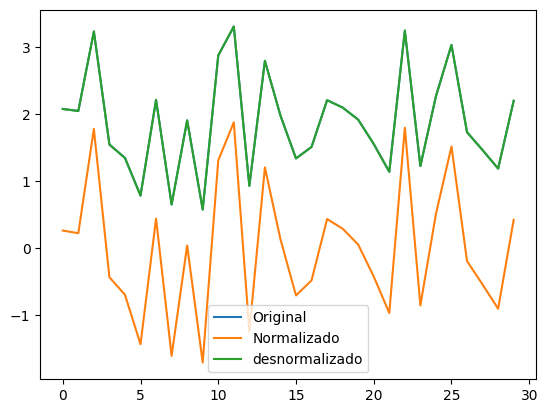

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 8.25 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-10-14 14:23:50.290408: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 14:23:50.290458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 14:23:50.292014: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 14:23:50.308463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 14:23:53.920360: W tensorflow/compiler/tf2

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [ ]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36],
                            [4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_6,0.090769,0.108548,0.086245,0.108129,0.242160,0.529204,0.433603,0.183326,0.264264,0.492097,-0.041341,0.495783,36.836316,86.225987
model_1_0_9,0.327557,0.087623,-0.195579,0.010763,0.179095,0.541626,0.567337,0.203340,0.210844,0.423196,0.229852,0.426366,37.439680,86.829351
model_1_0_8,0.319338,0.055582,-0.210949,-0.024070,0.181284,0.560648,0.574631,0.210500,0.217224,0.425774,0.220439,0.428964,37.415383,86.805054
model_1_0_7,0.306908,0.046345,-0.219291,-0.037897,0.184594,0.566131,0.578589,0.213342,0.219695,0.429644,0.206203,0.432863,37.379189,86.768861
model_1_0_5,-0.157699,-0.001059,-0.002417,-0.089346,0.308335,0.594272,0.475676,0.223918,0.304175,0.555279,-0.325911,0.559439,36.353135,85.742806
model_1_0_4,-0.177815,-0.011643,-0.011842,-0.105473,0.313693,0.600555,0.480149,0.227233,0.307016,0.560083,-0.348950,0.564278,36.318682,85.708353
model_1_0_3,-0.238430,-0.045544,-0.042132,-0.161620,0.329837,0.620680,0.494522,0.238774,0.313864,0.574314,-0.418373,0.578616,36.218314,85.607985
model_1_0_2,-0.254528,-0.058651,-0.058094,-0.177500,0.334124,0.628461,0.502097,0.242038,0.314338,0.578035,-0.436810,0.582365,36.192484,85.582156
model_1_0_1,-0.302548,-0.072934,-0.058680,-0.219513,0.346914,0.636940,0.502375,0.250674,0.321253,0.588994,-0.491808,0.593406,36.117358,85.507029
model_1_0_0,-0.449383,-0.162715,-0.107453,-0.387549,0.386021,0.690238,0.525519,0.285214,0.326130,0.621306,-0.659977,0.625960,35.903728,85.293399


DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_1] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_9,0.580839,0.261957,-0.036810,0.455073,0.111637,0.438134,0.491996,0.192933,0.161856,0.334121,0.519936,0.336624,38.385006,87.774677
model_1_1_8,0.577264,0.259664,-0.038557,0.450926,0.112589,0.439496,0.492825,0.194402,0.162668,0.335543,0.515840,0.338057,38.368016,87.757687
model_1_1_7,0.573621,0.257333,-0.040339,0.446700,0.113559,0.440879,0.493671,0.195898,0.163487,0.336986,0.511669,0.339510,38.350858,87.740529
model_1_1_6,0.569913,0.254963,-0.042158,0.442393,0.114547,0.442286,0.494535,0.197423,0.164314,0.338448,0.507422,0.340983,38.333538,87.723210
model_1_1_5,0.566138,0.252556,-0.044015,0.438004,0.115553,0.443715,0.495416,0.198977,0.165148,0.339930,0.503098,0.342477,38.316060,87.705731
model_1_1_4,0.562295,0.250109,-0.045909,0.433532,0.116576,0.445168,0.496314,0.200560,0.165990,0.341432,0.498697,0.343990,38.298423,87.688095
model_1_1_3,0.558381,0.247620,-0.047842,0.428977,0.117618,0.446645,0.497232,0.202173,0.166839,0.342955,0.494214,0.345524,38.280618,87.670290
model_1_1_2,0.554397,0.245091,-0.049816,0.424336,0.118680,0.448146,0.498168,0.203816,0.167696,0.344499,0.489651,0.347080,38.262656,87.652327
model_1_1_1,0.405068,0.148672,-0.135022,0.247021,0.158451,0.505385,0.538601,0.266595,0.196990,0.398059,0.318625,0.401041,37.684619,87.074291
model_1_1_0,0.368776,0.119439,-0.165985,0.200332,0.168117,0.522739,0.553294,0.283125,0.203731,0.410021,0.277059,0.413092,37.566191,86.955862


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  87
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_2] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_9,0.756650,0.381270,0.046168,0.659631,0.064812,0.367305,0.452621,0.125752,0.114862,0.254583,0.721292,0.256490,39.472516,88.862187
model_1_2_8,0.755938,0.380697,0.045781,0.659074,0.065002,0.367645,0.452805,0.125958,0.115063,0.254955,0.720476,0.256865,39.466671,88.856343
model_1_2_7,0.755212,0.380116,0.045388,0.658506,0.065196,0.367990,0.452991,0.126168,0.115266,0.255334,0.719645,0.257247,39.460729,88.850400
model_1_2_6,0.754471,0.379525,0.044988,0.657926,0.065393,0.368341,0.453181,0.126382,0.115485,0.255720,0.718796,0.257636,39.454687,88.844359
model_1_2_5,0.753716,0.378925,0.044582,0.657334,0.065594,0.368697,0.453374,0.126601,0.115706,0.256113,0.717931,0.258032,39.448545,88.838216
model_1_2_4,0.752946,0.378315,0.044170,0.656730,0.065799,0.369059,0.453569,0.126824,0.115929,0.256513,0.717049,0.258435,39.442301,88.831972
model_1_2_3,0.752161,0.377695,0.043752,0.656113,0.066008,0.369427,0.453768,0.127052,0.116163,0.256921,0.716150,0.258845,39.435953,88.825624
model_1_2_2,0.751360,0.377065,0.043326,0.655483,0.066222,0.369801,0.453970,0.127285,0.116409,0.257335,0.715233,0.259263,39.429500,88.819171
model_1_2_1,0.750543,0.376425,0.042894,0.654840,0.066439,0.370181,0.454175,0.127522,0.116667,0.257758,0.714297,0.259688,39.422941,88.812613
model_1_2_0,0.749710,0.375775,0.042455,0.654183,0.066661,0.370567,0.454383,0.127765,0.116928,0.258188,0.713343,0.260122,39.416275,88.805946


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_3] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.764996,0.390489,0.048772,0.769956,0.062590,0.361832,0.451386,0.039386,0.113307,0.250179,0.730851,0.252053,39.542312,88.931983
model_1_3_8,0.764263,0.389643,0.048521,0.770399,0.062785,0.362335,0.451505,0.039310,0.113444,0.250569,0.730011,0.252446,39.536080,88.925751
model_1_3_7,0.763512,0.388785,0.048279,0.770829,0.062985,0.362843,0.451620,0.039237,0.113587,0.250968,0.729150,0.252848,39.529715,88.919386
model_1_3_6,0.762741,0.387917,0.048045,0.771248,0.063190,0.363359,0.451731,0.039165,0.113733,0.251377,0.728268,0.253260,39.523212,88.912883
model_1_3_5,0.761951,0.387037,0.047819,0.771657,0.063401,0.363881,0.451838,0.039095,0.113881,0.251795,0.727363,0.253681,39.516564,88.906235
model_1_3_4,0.761141,0.386144,0.047600,0.772055,0.063617,0.364412,0.451942,0.039027,0.114036,0.252223,0.726435,0.254113,39.509764,88.899435
model_1_3_3,0.760307,0.385236,0.047386,0.772445,0.063838,0.364951,0.452043,0.038960,0.114200,0.252663,0.725480,0.254555,39.502799,88.892471
model_1_3_2,0.759449,0.384309,0.047168,0.772829,0.064067,0.365501,0.452146,0.038894,0.114366,0.253115,0.724498,0.255011,39.495652,88.885324
model_1_3_1,0.758562,0.383356,0.046932,0.773211,0.064303,0.366066,0.452258,0.038829,0.114532,0.253581,0.723481,0.255480,39.488289,88.877960
model_1_3_0,0.757636,0.382359,0.046637,0.773599,0.064550,0.366658,0.452399,0.038762,0.114699,0.254067,0.722421,0.255970,39.480636,88.870307


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  43
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_4] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.784247,0.406918,0.056764,0.765420,0.057462,0.352079,0.447593,0.067551,0.109878,0.239713,0.752899,0.241509,39.713247,89.102919
model_1_4_8,0.784012,0.406716,0.056725,0.765448,0.057525,0.352199,0.447611,0.067543,0.109896,0.239844,0.752629,0.241641,39.711067,89.100738
model_1_4_7,0.783771,0.406508,0.056683,0.765471,0.057589,0.352322,0.447631,0.067536,0.109913,0.239978,0.752353,0.241775,39.708839,89.098510
model_1_4_6,0.783525,0.406296,0.056636,0.765490,0.057655,0.352448,0.447654,0.067531,0.109931,0.240114,0.752071,0.241913,39.706561,89.096232
model_1_4_5,0.783273,0.406078,0.056585,0.765505,0.057722,0.352578,0.447678,0.067527,0.109956,0.240254,0.751782,0.242054,39.704234,89.093905
model_1_4_4,0.783015,0.405856,0.056529,0.765514,0.057791,0.352710,0.447704,0.067524,0.109982,0.240397,0.751487,0.242198,39.701856,89.091527
model_1_4_3,0.782751,0.405627,0.056469,0.765519,0.057861,0.352845,0.447733,0.067522,0.110009,0.240543,0.751185,0.242345,39.699426,89.089097
model_1_4_2,0.782481,0.405394,0.056403,0.765519,0.057933,0.352984,0.447764,0.067522,0.110035,0.240692,0.750876,0.242495,39.696943,89.086614
model_1_4_1,0.782205,0.405155,0.056333,0.765514,0.058006,0.353126,0.447797,0.067524,0.110062,0.240845,0.750560,0.242649,39.694407,89.084078
model_1_4_0,0.781923,0.404910,0.056258,0.765504,0.058082,0.353271,0.447833,0.067527,0.110090,0.241001,0.750236,0.242806,39.691816,89.081487


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_5] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.785609,0.409485,0.054581,0.696256,0.057100,0.350555,0.448629,0.107528,0.109236,0.238955,0.754459,0.240745,39.725914,89.115585
model_1_5_8,0.785499,0.409265,0.054821,0.696682,0.057129,0.350686,0.448515,0.107378,0.109282,0.239017,0.754332,0.240807,39.724882,89.114553
model_1_5_7,0.785383,0.409039,0.055059,0.697108,0.057160,0.350820,0.448402,0.107227,0.109328,0.239081,0.754200,0.240872,39.723806,89.113477
model_1_5_6,0.785263,0.408806,0.055294,0.697535,0.057192,0.350958,0.448290,0.107076,0.109382,0.239148,0.754062,0.240940,39.722685,89.112356
model_1_5_5,0.785137,0.408566,0.055526,0.697962,0.057225,0.351101,0.448180,0.106925,0.109443,0.239218,0.753918,0.241010,39.721515,89.111187
model_1_5_4,0.785006,0.408318,0.055754,0.698390,0.057260,0.351248,0.448072,0.106773,0.109511,0.239291,0.753768,0.241084,39.720296,89.109967
model_1_5_3,0.784869,0.408061,0.055977,0.698818,0.057297,0.351400,0.447967,0.106621,0.109580,0.239367,0.753611,0.241161,39.719021,89.108693
model_1_5_2,0.784726,0.407795,0.056193,0.699248,0.057335,0.351558,0.447864,0.106469,0.109650,0.239447,0.753447,0.241241,39.717688,89.107359
model_1_5_1,0.784575,0.407518,0.056401,0.699678,0.057375,0.351723,0.447765,0.106317,0.109722,0.239531,0.753274,0.241325,39.716289,89.105960
model_1_5_0,0.784416,0.407227,0.056595,0.700110,0.057417,0.351896,0.447673,0.106164,0.109796,0.239619,0.753092,0.241414,39.714815,89.104486


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_6] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.788451,0.411121,0.052199,0.801512,0.056343,0.349584,0.449759,0.033023,0.108866,0.237367,0.757713,0.239145,39.752597,89.142268
model_1_6_8,0.788190,0.410978,0.052437,0.801941,0.056412,0.349669,0.449647,0.032952,0.108900,0.237513,0.757414,0.239292,39.750137,89.139808
model_1_6_7,0.787925,0.410830,0.052675,0.802370,0.056483,0.349756,0.449533,0.032880,0.108933,0.237661,0.757111,0.239442,39.747634,89.137305
model_1_6_6,0.787655,0.410679,0.052915,0.802799,0.056555,0.349846,0.449420,0.032809,0.108966,0.237813,0.756801,0.239594,39.745087,89.134758
model_1_6_5,0.787379,0.410523,0.053154,0.803227,0.056628,0.349939,0.449306,0.032738,0.108998,0.237967,0.756486,0.239749,39.742495,89.132166
model_1_6_4,0.787099,0.410363,0.053394,0.803656,0.056703,0.350034,0.449192,0.032666,0.109030,0.238124,0.756164,0.239908,39.739857,89.129528
model_1_6_3,0.786813,0.410198,0.053634,0.804083,0.056779,0.350132,0.449078,0.032595,0.109061,0.238284,0.755837,0.240069,39.737170,89.126841
model_1_6_2,0.786521,0.410028,0.053873,0.804509,0.056857,0.350233,0.448965,0.032524,0.109100,0.238447,0.755502,0.240233,39.734435,89.124106
model_1_6_1,0.786223,0.409853,0.054111,0.804935,0.056936,0.350337,0.448852,0.032454,0.109143,0.238613,0.755161,0.240400,39.731648,89.121319
model_1_6_0,0.785919,0.409672,0.054347,0.805361,0.057017,0.350444,0.448740,0.032383,0.109190,0.238783,0.754814,0.240571,39.728808,89.118480


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_7] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.790334,0.413989,0.050737,0.727412,0.055841,0.347882,0.450453,0.071367,0.108357,0.236308,0.759869,0.238078,39.770479,89.160150
model_1_7_8,0.790159,0.413722,0.050895,0.727517,0.055888,0.348040,0.450378,0.071340,0.108402,0.236406,0.759669,0.238177,39.768815,89.158486
model_1_7_7,0.789982,0.413451,0.051051,0.727618,0.055935,0.348201,0.450304,0.071313,0.108448,0.236506,0.759466,0.238278,39.767125,89.156797
model_1_7_6,0.789802,0.413176,0.051204,0.727712,0.055983,0.348364,0.450231,0.071289,0.108498,0.236608,0.759260,0.238380,39.765409,89.155081
model_1_7_5,0.789618,0.412896,0.051355,0.727802,0.056032,0.348530,0.450160,0.071265,0.108548,0.236711,0.759050,0.238484,39.763666,89.153338
model_1_7_4,0.789432,0.412612,0.051502,0.727887,0.056082,0.348699,0.450090,0.071243,0.108598,0.236816,0.758837,0.238589,39.761896,89.151567
model_1_7_3,0.789242,0.412323,0.051647,0.727966,0.056132,0.348870,0.450021,0.071222,0.108647,0.236922,0.758619,0.238697,39.760096,89.149767
model_1_7_2,0.789050,0.412029,0.051789,0.728040,0.056183,0.349045,0.449954,0.071203,0.108698,0.237030,0.758399,0.238806,39.758268,89.147939
model_1_7_1,0.788853,0.411731,0.051928,0.728108,0.056236,0.349222,0.449888,0.071185,0.108754,0.237141,0.758174,0.238917,39.756409,89.146080
model_1_7_0,0.788654,0.411429,0.052065,0.728171,0.056289,0.349401,0.449823,0.071168,0.108810,0.237253,0.757945,0.239030,39.754519,89.144190


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_8] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_9,0.792725,0.417071,0.048167,0.834956,0.055205,0.346052,0.451673,0.050164,0.108436,0.234957,0.762608,0.236717,39.793418,89.183089
model_1_8_8,0.792509,0.416786,0.048345,0.835496,0.055262,0.346221,0.451588,0.050000,0.108426,0.235079,0.762361,0.236840,39.791339,89.181010
model_1_8_7,0.792289,0.416496,0.048541,0.836037,0.055321,0.346393,0.451495,0.049836,0.108421,0.235204,0.762108,0.236965,39.789215,89.178886
model_1_8_6,0.792063,0.416201,0.048756,0.836578,0.055381,0.346568,0.451393,0.049671,0.108418,0.235331,0.761850,0.237094,39.787044,89.176715
model_1_8_5,0.791832,0.415901,0.048989,0.837119,0.055442,0.346746,0.451283,0.049507,0.108414,0.235462,0.761586,0.237226,39.784827,89.174498
model_1_8_4,0.791596,0.415596,0.049238,0.837658,0.055505,0.346928,0.451164,0.049343,0.108408,0.235595,0.761316,0.237360,39.782561,89.172233
model_1_8_3,0.791355,0.415285,0.049506,0.838194,0.055569,0.347112,0.451037,0.049180,0.108401,0.235731,0.761039,0.237497,39.780247,89.169919
model_1_8_2,0.791108,0.414969,0.049789,0.838725,0.055635,0.347300,0.450903,0.049019,0.108392,0.235871,0.760757,0.237638,39.777884,89.167555
model_1_8_1,0.790856,0.414648,0.050089,0.839250,0.055702,0.347490,0.450760,0.048859,0.108382,0.236013,0.760468,0.237781,39.775469,89.165140
model_1_8_0,0.790598,0.414321,0.050405,0.839768,0.055771,0.347684,0.450610,0.048702,0.108370,0.236159,0.760172,0.237928,39.773001,89.162672


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_9] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_9,0.793664,0.418214,0.047210,0.823964,0.054955,0.345373,0.452127,0.063735,0.107846,0.234424,0.763683,0.236180,39.802499,89.192170
model_1_9_8,0.793575,0.418108,0.047275,0.824111,0.054978,0.345436,0.452096,0.063681,0.107901,0.234474,0.763582,0.236230,39.801644,89.191315
model_1_9_7,0.793486,0.418000,0.047347,0.824264,0.055002,0.345500,0.452062,0.063626,0.107958,0.234525,0.763480,0.236281,39.800777,89.190448
model_1_9_6,0.793395,0.417891,0.047426,0.824422,0.055026,0.345565,0.452024,0.063569,0.108015,0.234576,0.763376,0.236333,39.799898,89.189570
model_1_9_5,0.793303,0.417781,0.047512,0.824584,0.055051,0.345631,0.451984,0.063510,0.108073,0.234628,0.763270,0.236386,39.799008,89.188679
model_1_9_4,0.793210,0.417668,0.047604,0.824752,0.055075,0.345697,0.451940,0.063449,0.108131,0.234681,0.763164,0.236439,39.798106,89.187777
model_1_9_3,0.793115,0.417554,0.047704,0.824923,0.055101,0.345765,0.451892,0.063387,0.108191,0.234735,0.763055,0.236493,39.797192,89.186863
model_1_9_2,0.793020,0.417437,0.047810,0.825099,0.055126,0.345835,0.451842,0.063324,0.108251,0.234789,0.762946,0.236548,39.796267,89.185938
model_1_9_1,0.792923,0.417318,0.047923,0.825279,0.055152,0.345905,0.451788,0.063259,0.108312,0.234844,0.762834,0.236604,39.795329,89.185000
model_1_9_0,0.792824,0.417196,0.048042,0.825462,0.055178,0.345978,0.451732,0.063192,0.108374,0.234900,0.762722,0.236660,39.794379,89.184050


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_10] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_9,0.794796,0.419681,0.044614,0.846102,0.054653,0.344502,0.453359,0.036501,0.107875,0.233780,0.764980,0.235531,39.813500,89.203172
model_1_10_8,0.794690,0.419545,0.044841,0.846060,0.054681,0.344583,0.453251,0.036511,0.107874,0.233840,0.764859,0.235592,39.812471,89.202142
model_1_10_7,0.794583,0.419406,0.045074,0.846019,0.054710,0.344665,0.453140,0.036521,0.107873,0.233901,0.764736,0.235653,39.811428,89.201099
model_1_10_6,0.794474,0.419266,0.045315,0.845980,0.054739,0.344749,0.453026,0.036530,0.107871,0.233963,0.764611,0.235715,39.810371,89.200042
model_1_10_5,0.794364,0.419123,0.045562,0.845941,0.054768,0.344834,0.452909,0.036539,0.107869,0.234026,0.764485,0.235779,39.809298,89.198969
model_1_10_4,0.794252,0.418977,0.045817,0.845904,0.054798,0.344920,0.452788,0.036548,0.107866,0.234089,0.764357,0.235843,39.808209,89.197880
model_1_10_3,0.794138,0.418829,0.046079,0.845868,0.054828,0.345008,0.452663,0.036557,0.107863,0.234154,0.764227,0.235908,39.807104,89.196775
model_1_10_2,0.794023,0.418679,0.046349,0.845832,0.054859,0.345097,0.452535,0.036565,0.107859,0.234220,0.764094,0.235974,39.805980,89.195652
model_1_10_1,0.793905,0.418527,0.046628,0.845798,0.054890,0.345188,0.452403,0.036573,0.107855,0.234287,0.763960,0.236042,39.804839,89.194510
model_1_10_0,0.793785,0.418372,0.046914,0.845765,0.054922,0.345280,0.452267,0.036581,0.107851,0.234355,0.763823,0.236110,39.803679,89.193350


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_11] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_9,0.796975,0.422359,0.049130,0.813181,0.054073,0.342913,0.451215,0.036494,0.107988,0.232535,0.767475,0.234277,39.834852,89.224523
model_1_11_8,0.796780,0.422110,0.048694,0.813939,0.054125,0.343060,0.451422,0.036346,0.107974,0.232647,0.767252,0.234389,39.832936,89.222607
model_1_11_7,0.796580,0.421858,0.048255,0.814702,0.054178,0.343210,0.451631,0.036197,0.107966,0.232761,0.767024,0.234505,39.830973,89.220644
model_1_11_6,0.796376,0.421601,0.047813,0.815470,0.054232,0.343362,0.451841,0.036047,0.107957,0.232878,0.766790,0.234622,39.828964,89.218635
model_1_11_5,0.796166,0.421341,0.047367,0.816244,0.054288,0.343517,0.452052,0.035896,0.107948,0.232998,0.766550,0.234743,39.826907,89.216578
model_1_11_4,0.795952,0.421075,0.046918,0.817023,0.054345,0.343675,0.452265,0.035744,0.107937,0.233120,0.766304,0.234867,39.824801,89.214472
model_1_11_3,0.795732,0.420806,0.046465,0.817808,0.054404,0.343835,0.452480,0.035590,0.107924,0.233246,0.766052,0.234993,39.822646,89.212317
model_1_11_2,0.795506,0.420532,0.046009,0.818597,0.054464,0.343997,0.452697,0.035436,0.107913,0.233375,0.765794,0.235123,39.820439,89.210111
model_1_11_1,0.795275,0.420253,0.045548,0.819392,0.054525,0.344163,0.452915,0.035281,0.107901,0.233507,0.765529,0.235256,39.818181,89.207852
model_1_11_0,0.795038,0.419969,0.045083,0.820191,0.054588,0.344331,0.453136,0.035125,0.107889,0.233642,0.765258,0.235392,39.815868,89.205540


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_12] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_9,0.798730,0.425867,0.048739,0.746593,0.053605,0.340830,0.451401,0.045709,0.108270,0.231528,0.769486,0.233262,39.852224,89.241895
model_1_12_8,0.798572,0.425535,0.048781,0.747236,0.053647,0.341027,0.451381,0.045593,0.108244,0.231619,0.769305,0.233354,39.850649,89.240320
model_1_12_7,0.798410,0.425199,0.048822,0.747876,0.053690,0.341227,0.451362,0.045478,0.108217,0.231712,0.769119,0.233448,39.849040,89.238712
model_1_12_6,0.798244,0.424859,0.048862,0.748514,0.053735,0.341428,0.451343,0.045363,0.108190,0.231807,0.768929,0.233544,39.847396,89.237068
model_1_12_5,0.798075,0.424515,0.048902,0.749149,0.053780,0.341633,0.451324,0.045248,0.108163,0.231905,0.768735,0.233642,39.845716,89.235387
model_1_12_4,0.797901,0.424167,0.048942,0.749781,0.053826,0.341839,0.451305,0.045134,0.108135,0.232004,0.768536,0.233742,39.844000,89.233671
model_1_12_3,0.797724,0.423814,0.048981,0.750411,0.053873,0.342049,0.451287,0.045021,0.108107,0.232106,0.768333,0.233844,39.842247,89.231918
model_1_12_2,0.797543,0.423457,0.049019,0.751038,0.053921,0.342261,0.451268,0.044907,0.108078,0.232210,0.768126,0.233949,39.840456,89.230127
model_1_12_1,0.797358,0.423096,0.049057,0.751662,0.053971,0.342475,0.451250,0.044795,0.108048,0.232316,0.767914,0.234056,39.838627,89.228298
model_1_12_0,0.797168,0.422730,0.049094,0.752282,0.054021,0.342693,0.451233,0.044683,0.108018,0.232424,0.767697,0.234166,39.836759,89.226431


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_13] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_9,0.800063,0.426802,0.046635,0.861891,0.053250,0.340275,0.452399,0.026477,0.108010,0.230760,0.771013,0.232488,39.865511,89.255182
model_1_13_8,0.799955,0.426726,0.046850,0.862299,0.053279,0.340320,0.452298,0.026398,0.108029,0.230822,0.770889,0.232551,39.864434,89.254105
model_1_13_7,0.799842,0.426646,0.047064,0.862694,0.053309,0.340367,0.452196,0.026323,0.108048,0.230887,0.770760,0.232617,39.863304,89.252976
model_1_13_6,0.799724,0.426563,0.047277,0.863076,0.053340,0.340417,0.452095,0.026250,0.108067,0.230955,0.770624,0.232685,39.862122,89.251793
model_1_13_5,0.799600,0.426476,0.047489,0.863443,0.053373,0.340469,0.451994,0.026179,0.108086,0.231027,0.770482,0.232757,39.860885,89.250557
model_1_13_4,0.799471,0.426385,0.047700,0.863795,0.053408,0.340523,0.451894,0.026112,0.108106,0.231102,0.770334,0.232833,39.859592,89.249264
model_1_13_3,0.799335,0.426290,0.047911,0.864133,0.053444,0.340579,0.451794,0.026047,0.108130,0.231180,0.770179,0.232911,39.858242,89.247913
model_1_13_2,0.799194,0.426190,0.048120,0.864454,0.053482,0.340638,0.451695,0.025985,0.108164,0.231261,0.770017,0.232993,39.856831,89.246503
model_1_13_1,0.799046,0.426087,0.048327,0.864758,0.053521,0.340700,0.451596,0.025927,0.108199,0.231346,0.769847,0.233079,39.855360,89.245031
model_1_13_0,0.798891,0.425979,0.048534,0.865046,0.053562,0.340764,0.451499,0.025872,0.108234,0.231435,0.769671,0.233169,39.853824,89.243496


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_14] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_9,0.801145,0.429015,0.047204,0.837095,0.052962,0.338961,0.452129,0.031437,0.108325,0.230134,0.772252,0.231858,39.876366,89.266037
model_1_14_8,0.801052,0.428799,0.047129,0.837599,0.052987,0.339089,0.452165,0.031340,0.108295,0.230188,0.772145,0.231913,39.875428,89.265099
model_1_14_7,0.800956,0.428582,0.047057,0.838104,0.053012,0.339218,0.452199,0.031242,0.108264,0.230244,0.772035,0.231969,39.874457,89.264128
model_1_14_6,0.800856,0.428363,0.046990,0.838610,0.053039,0.339348,0.452231,0.031144,0.108233,0.230302,0.771920,0.232027,39.873454,89.263125
model_1_14_5,0.800753,0.428143,0.046926,0.839118,0.053067,0.339479,0.452262,0.031046,0.108202,0.230362,0.771802,0.232087,39.872419,89.262090
model_1_14_4,0.800646,0.427922,0.046866,0.839627,0.053095,0.339610,0.452290,0.030948,0.108171,0.230423,0.771680,0.232149,39.871350,89.261022
model_1_14_3,0.800536,0.427700,0.046811,0.840137,0.053124,0.339742,0.452316,0.030850,0.108139,0.230487,0.771554,0.232213,39.870250,89.259921
model_1_14_2,0.800423,0.427477,0.046760,0.840648,0.053154,0.339875,0.452340,0.030751,0.108107,0.230552,0.771425,0.232279,39.869115,89.258787
model_1_14_1,0.800307,0.427253,0.046713,0.841161,0.053185,0.340008,0.452362,0.030652,0.108075,0.230619,0.771291,0.232347,39.867947,89.257618
model_1_14_0,0.800187,0.427028,0.046672,0.841675,0.053217,0.340141,0.452382,0.030553,0.108043,0.230689,0.771154,0.232417,39.866746,89.256417


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_15] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_9,0.801330,0.429268,0.048158,0.801850,0.052913,0.338811,0.451677,0.083784,0.108045,0.230028,0.772463,0.231751,39.878220,89.267891
model_1_15_8,0.801319,0.429247,0.048070,0.802016,0.052916,0.338824,0.451719,0.083714,0.108073,0.230034,0.772451,0.231757,39.878117,89.267789
model_1_15_7,0.801307,0.429224,0.047981,0.802181,0.052919,0.338837,0.451761,0.083644,0.108100,0.230041,0.772437,0.231764,39.877993,89.267664
model_1_15_6,0.801293,0.429201,0.047889,0.802347,0.052923,0.338851,0.451804,0.083574,0.108128,0.230049,0.772421,0.231772,39.877848,89.267519
model_1_15_5,0.801276,0.429177,0.047796,0.802513,0.052927,0.338865,0.451848,0.083504,0.108157,0.230059,0.772402,0.231782,39.877683,89.267354
model_1_15_4,0.801258,0.429151,0.047702,0.802679,0.052932,0.338881,0.451893,0.083434,0.108185,0.230069,0.772381,0.231793,39.877499,89.267170
model_1_15_3,0.801238,0.429125,0.047606,0.802846,0.052937,0.338896,0.451939,0.083363,0.108213,0.230081,0.772358,0.231804,39.877299,89.266971
model_1_15_2,0.801217,0.429099,0.047508,0.803013,0.052943,0.338912,0.451985,0.083293,0.108241,0.230093,0.772334,0.231817,39.877085,89.266756
model_1_15_1,0.801194,0.429071,0.047408,0.803182,0.052949,0.338928,0.452033,0.083221,0.108270,0.230106,0.772308,0.231830,39.876857,89.266529
model_1_15_0,0.801170,0.429044,0.047307,0.803352,0.052955,0.338944,0.452081,0.083149,0.108298,0.230120,0.772281,0.231844,39.876617,89.266289


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_16] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_9,0.801790,0.430132,0.045936,0.749415,0.052790,0.338298,0.452731,0.061625,0.108051,0.229761,0.772990,0.231483,39.882855,89.272526
model_1_16_8,0.801752,0.430058,0.046163,0.749766,0.052800,0.338342,0.452624,0.061539,0.108046,0.229783,0.772947,0.231505,39.882474,89.272146
model_1_16_7,0.801712,0.429981,0.046389,0.750120,0.052811,0.338388,0.452516,0.061452,0.108044,0.229806,0.772901,0.231528,39.882076,89.271747
model_1_16_6,0.801671,0.429901,0.046615,0.750476,0.052822,0.338435,0.452409,0.061364,0.108042,0.229830,0.772854,0.231552,39.881661,89.271333
model_1_16_5,0.801628,0.429819,0.046839,0.750835,0.052833,0.338484,0.452303,0.061276,0.108040,0.229855,0.772805,0.231577,39.881228,89.270899
model_1_16_4,0.801583,0.429734,0.047062,0.751195,0.052845,0.338534,0.452197,0.061187,0.108038,0.229881,0.772754,0.231603,39.880776,89.270447
model_1_16_3,0.801537,0.429647,0.047284,0.751558,0.052858,0.338586,0.452091,0.061098,0.108037,0.229908,0.772700,0.231630,39.880306,89.269977
model_1_16_2,0.801488,0.429556,0.047505,0.751924,0.052871,0.338640,0.451987,0.061008,0.108039,0.229936,0.772644,0.231659,39.879815,89.269486
model_1_16_1,0.801437,0.429463,0.047724,0.752291,0.052884,0.338695,0.451883,0.060918,0.108041,0.229965,0.772586,0.231688,39.879304,89.268976
model_1_16_0,0.801385,0.429367,0.047942,0.752661,0.052898,0.338752,0.451779,0.060827,0.108043,0.229996,0.772526,0.231719,39.878773,89.268444


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_17] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_7,0.801331,0.432672,0.043069,0.895242,0.052912,0.336791,0.454092,0.025031,0.108786,0.230027,0.772465,0.231750,39.878233,89.267904
model_1_17_6,0.801182,0.432669,0.043233,0.894845,0.052952,0.336792,0.454014,0.025126,0.108806,0.230113,0.772294,0.231837,39.876739,89.266410
model_1_17_8,0.801484,0.432668,0.042905,0.895674,0.052872,0.336793,0.454169,0.024927,0.108762,0.229939,0.772639,0.231661,39.879771,89.269442
model_1_17_5,0.801039,0.432660,0.043397,0.894487,0.052990,0.336797,0.453936,0.025211,0.108823,0.230196,0.772130,0.231920,39.875296,89.264967
model_1_17_9,0.801637,0.432660,0.042741,0.896124,0.052831,0.336798,0.454247,0.024820,0.108736,0.229850,0.772815,0.231571,39.881320,89.270992
model_1_17_4,0.800901,0.432646,0.043561,0.894171,0.053027,0.336806,0.453858,0.025286,0.108837,0.230276,0.771972,0.232001,39.873908,89.263580
model_1_17_3,0.800768,0.432626,0.043725,0.893895,0.053062,0.336818,0.453780,0.025352,0.108849,0.230353,0.771820,0.232078,39.872574,89.262245
model_1_17_2,0.800640,0.432601,0.043889,0.893657,0.053097,0.336833,0.453703,0.025409,0.108860,0.230427,0.771673,0.232153,39.871287,89.260958
model_1_17_1,0.800516,0.432571,0.044052,0.893453,0.053130,0.336850,0.453625,0.025458,0.108872,0.230499,0.771531,0.232225,39.870043,89.259715
model_1_17_0,0.800395,0.432537,0.044215,0.893280,0.053162,0.336871,0.453548,0.025499,0.108882,0.230568,0.771393,0.232295,39.868837,89.258508


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_18] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_9,0.802188,0.433710,0.042275,0.804845,0.052684,0.336174,0.454469,0.035768,0.109123,0.229530,0.773446,0.231250,39.886879,89.276550
model_1_18_8,0.802141,0.433613,0.042326,0.805290,0.052697,0.336232,0.454444,0.035686,0.109082,0.229557,0.773393,0.231277,39.886409,89.276080
model_1_18_7,0.802093,0.433514,0.042376,0.805739,0.052709,0.336291,0.454421,0.035604,0.109041,0.229585,0.773337,0.231305,39.885921,89.275592
model_1_18_6,0.802043,0.433413,0.042425,0.806190,0.052723,0.336350,0.454397,0.035521,0.108999,0.229614,0.773280,0.231334,39.885415,89.275087
model_1_18_5,0.801991,0.433311,0.042473,0.806643,0.052737,0.336411,0.454374,0.035438,0.108958,0.229645,0.773221,0.231365,39.884891,89.274562
model_1_18_4,0.801937,0.433207,0.042521,0.807099,0.052751,0.336473,0.454352,0.035355,0.108922,0.229676,0.773159,0.231396,39.884347,89.274018
model_1_18_3,0.801881,0.433101,0.042567,0.807558,0.052766,0.336536,0.454330,0.035271,0.108886,0.229708,0.773095,0.231429,39.883783,89.273454
model_1_18_2,0.801824,0.432994,0.042613,0.808019,0.052781,0.336599,0.454308,0.035186,0.108849,0.229742,0.773029,0.231463,39.883199,89.272870
model_1_18_1,0.801764,0.432884,0.042657,0.808482,0.052797,0.336664,0.454287,0.035101,0.108812,0.229776,0.772960,0.231498,39.882594,89.272266
model_1_18_0,0.801702,0.432773,0.042700,0.808948,0.052814,0.336730,0.454267,0.035016,0.108774,0.229812,0.772889,0.231534,39.881968,89.271640


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_19] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_9,0.802427,0.435192,0.044073,0.805947,0.052620,0.335294,0.453615,0.043072,0.109097,0.229391,0.773720,0.231110,39.889302,89.278974
model_1_19_8,0.802407,0.435051,0.043903,0.806104,0.052626,0.335378,0.453696,0.043037,0.109098,0.229403,0.773697,0.231122,39.889093,89.278764
model_1_19_7,0.802385,0.434909,0.043731,0.806264,0.052632,0.335462,0.453777,0.043002,0.109098,0.229416,0.773672,0.231134,39.888877,89.278548
model_1_19_6,0.802363,0.434765,0.043557,0.806424,0.052637,0.335548,0.453860,0.042966,0.109099,0.229429,0.773647,0.231147,39.888654,89.278325
model_1_19_5,0.802341,0.434620,0.043381,0.806586,0.052644,0.335634,0.453944,0.042930,0.109099,0.229442,0.773621,0.231160,39.888423,89.278095
model_1_19_4,0.802317,0.434473,0.043203,0.806749,0.052650,0.335722,0.454028,0.042894,0.109099,0.229455,0.773594,0.231174,39.888185,89.277857
model_1_19_3,0.802293,0.434324,0.043022,0.806914,0.052656,0.335810,0.454114,0.042857,0.109103,0.229470,0.773566,0.231188,39.887940,89.277611
model_1_19_2,0.802268,0.434173,0.042839,0.807080,0.052663,0.335899,0.454201,0.042821,0.109108,0.229484,0.773538,0.231203,39.887687,89.277358
model_1_19_1,0.802242,0.434020,0.042653,0.807247,0.052670,0.335990,0.454289,0.042783,0.109113,0.229499,0.773508,0.231218,39.887426,89.277097
model_1_19_0,0.802215,0.433866,0.042465,0.807416,0.052677,0.336082,0.454378,0.042746,0.109118,0.229515,0.773477,0.231234,39.887156,89.276827


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_20] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_9,0.802730,0.436704,0.045437,0.807607,0.052540,0.334397,0.452968,0.041193,0.109351,0.229216,0.774067,0.230933,39.892370,89.282041
model_1_20_8,0.802707,0.436556,0.045310,0.807911,0.052546,0.334484,0.453028,0.041128,0.109317,0.229229,0.774040,0.230946,39.892130,89.281801
model_1_20_7,0.802682,0.436408,0.045182,0.808214,0.052553,0.334572,0.453089,0.041063,0.109284,0.229244,0.774011,0.230961,39.891876,89.281547
model_1_20_6,0.802655,0.436259,0.045051,0.808518,0.052560,0.334661,0.453151,0.040998,0.109254,0.229259,0.773981,0.230977,39.891607,89.281279
model_1_20_5,0.802627,0.436109,0.044919,0.808821,0.052567,0.334750,0.453214,0.040933,0.109232,0.229275,0.773949,0.230993,39.891324,89.280996
model_1_20_4,0.802598,0.435959,0.044784,0.809125,0.052575,0.334839,0.453278,0.040868,0.109210,0.229293,0.773915,0.231010,39.891027,89.280698
model_1_20_3,0.802567,0.435807,0.044647,0.809429,0.052583,0.334929,0.453343,0.040803,0.109188,0.229310,0.773880,0.231028,39.890714,89.280385
model_1_20_2,0.802534,0.435654,0.044508,0.809734,0.052592,0.335020,0.453409,0.040738,0.109166,0.229329,0.773843,0.231047,39.890385,89.280056
model_1_20_1,0.802500,0.435501,0.044365,0.810038,0.052601,0.335111,0.453477,0.040673,0.109143,0.229349,0.773804,0.231067,39.890041,89.279712
model_1_20_0,0.802465,0.435347,0.044221,0.810343,0.052610,0.335202,0.453545,0.040607,0.109120,0.229370,0.773763,0.231088,39.889680,89.279351


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_21] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_9,0.802901,0.438158,0.045383,0.851601,0.052494,0.333533,0.452994,0.029408,0.109625,0.229116,0.774263,0.230833,39.894103,89.283774
model_1_21_8,0.802889,0.438021,0.045383,0.851905,0.052497,0.333615,0.452994,0.029348,0.109597,0.229123,0.774249,0.230839,39.893983,89.283654
model_1_21_7,0.802876,0.437882,0.045384,0.852210,0.052501,0.333697,0.452993,0.029287,0.109569,0.229131,0.774235,0.230847,39.893853,89.283524
model_1_21_6,0.802863,0.437742,0.045386,0.852517,0.052505,0.333781,0.452992,0.029227,0.109541,0.229139,0.774219,0.230855,39.893711,89.283383
model_1_21_5,0.802847,0.437599,0.045389,0.852824,0.052509,0.333865,0.452991,0.029166,0.109512,0.229147,0.774201,0.230864,39.893558,89.283229
model_1_21_4,0.802831,0.437455,0.045394,0.853133,0.052513,0.333951,0.452989,0.029104,0.109485,0.229157,0.774183,0.230873,39.893393,89.283064
model_1_21_3,0.802814,0.437308,0.045400,0.853442,0.052518,0.334038,0.452986,0.029043,0.109458,0.229167,0.774163,0.230884,39.893215,89.282887
model_1_21_2,0.802795,0.437160,0.045407,0.853753,0.052523,0.334126,0.452982,0.028982,0.109431,0.229178,0.774141,0.230895,39.893025,89.282696
model_1_21_1,0.802775,0.437010,0.045415,0.854064,0.052528,0.334215,0.452978,0.028920,0.109403,0.229190,0.774118,0.230907,39.892820,89.282492
model_1_21_0,0.802753,0.436858,0.045425,0.854376,0.052534,0.334306,0.452974,0.028858,0.109376,0.229202,0.774093,0.230919,39.892603,89.282274


DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_22] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_9,0.802918,0.438310,0.045482,0.836105,0.052490,0.333443,0.452946,0.061219,0.109268,0.229107,0.774282,0.230823,39.894271,89.283942
model_1_22_8,0.802921,0.438300,0.045471,0.836379,0.052489,0.333449,0.452952,0.061117,0.109294,0.229104,0.774286,0.230821,39.894309,89.283980
model_1_22_7,0.802924,0.438289,0.045459,0.836655,0.052488,0.333456,0.452957,0.061014,0.109326,0.229103,0.774289,0.230819,39.894336,89.284007
model_1_22_6,0.802926,0.438277,0.045448,0.836931,0.052488,0.333463,0.452963,0.060910,0.109358,0.229102,0.774291,0.230818,39.894352,89.284023
model_1_22_5,0.802926,0.438264,0.045438,0.837209,0.052488,0.333471,0.452968,0.060807,0.109390,0.229102,0.774291,0.230818,39.894356,89.284027
model_1_22_4,0.802925,0.438250,0.045428,0.837487,0.052488,0.333479,0.452972,0.060703,0.109423,0.229102,0.774290,0.230818,39.894347,89.284018
model_1_22_3,0.802923,0.438234,0.045418,0.837767,0.052488,0.333488,0.452977,0.060598,0.109462,0.229103,0.774288,0.230820,39.894326,89.283997
model_1_22_2,0.802920,0.438217,0.045409,0.838047,0.052489,0.333498,0.452981,0.060494,0.109501,0.229105,0.774284,0.230822,39.894291,89.283963
model_1_22_1,0.802915,0.438199,0.045400,0.838329,0.052491,0.333509,0.452986,0.060388,0.109542,0.229108,0.774279,0.230824,39.894243,89.283914
model_1_22_0,0.802909,0.438179,0.045391,0.838611,0.052492,0.333521,0.452990,0.060283,0.109583,0.229112,0.774272,0.230828,39.894180,89.283851


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_23] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_0,0.802967,0.438256,0.044878,0.793248,0.052477,0.333475,0.453233,0.052660,0.109226,0.229078,0.774339,0.230794,39.894775,89.284446
model_1_23_1,0.802981,0.438238,0.044682,0.793041,0.052473,0.333486,0.453326,0.052712,0.109215,0.229070,0.774355,0.230785,39.894918,89.284590
model_1_23_2,0.802995,0.438219,0.044488,0.792836,0.052469,0.333497,0.453418,0.052765,0.109203,0.229062,0.774370,0.230778,39.895051,89.284722
model_1_23_3,0.803007,0.438200,0.044297,0.792632,0.052466,0.333509,0.453509,0.052817,0.109192,0.229055,0.774384,0.230771,39.895173,89.284844
model_1_23_4,0.803018,0.438181,0.044109,0.792429,0.052463,0.333520,0.453598,0.052868,0.109182,0.229049,0.774396,0.230764,39.895284,89.284956
model_1_23_5,0.803028,0.438162,0.043922,0.792226,0.052461,0.333532,0.453687,0.052920,0.109171,0.229043,0.774408,0.230758,39.895386,89.285057
model_1_23_6,0.803037,0.438142,0.043738,0.792025,0.052458,0.333543,0.453774,0.052971,0.109165,0.229037,0.774418,0.230753,39.895478,89.285150
model_1_23_7,0.803045,0.438122,0.043556,0.791825,0.052456,0.333555,0.453860,0.053022,0.109158,0.229033,0.774427,0.230748,39.895562,89.285233
model_1_23_8,0.803052,0.438102,0.043377,0.791626,0.052454,0.333567,0.453946,0.053073,0.109152,0.229028,0.774436,0.230744,39.895636,89.285307
model_1_23_9,0.803059,0.438082,0.043199,0.791428,0.052452,0.333579,0.454030,0.053123,0.109146,0.229025,0.774443,0.230740,39.895703,89.285374


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_24] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_0,0.803091,0.437943,0.043340,0.840018,0.052444,0.333662,0.453963,0.049363,0.109149,0.229006,0.774481,0.230721,39.896033,89.285704
model_1_24_1,0.803122,0.437803,0.043478,0.839765,0.052436,0.333744,0.453898,0.049441,0.109152,0.228988,0.774516,0.230703,39.896343,89.286014
model_1_24_2,0.803150,0.437664,0.043613,0.839509,0.052428,0.333827,0.453834,0.049520,0.109155,0.228972,0.774548,0.230687,39.896629,89.286300
model_1_24_3,0.803176,0.437525,0.043745,0.839250,0.052421,0.333909,0.453771,0.049600,0.109163,0.228956,0.774578,0.230671,39.896894,89.286566
model_1_24_4,0.803200,0.437387,0.043874,0.838988,0.052415,0.333992,0.453710,0.049681,0.109174,0.228943,0.774605,0.230657,39.897137,89.286808
model_1_24_5,0.803221,0.437248,0.044001,0.838722,0.052409,0.334074,0.453650,0.049763,0.109186,0.228930,0.774630,0.230645,39.897355,89.287026
model_1_24_6,0.803241,0.437110,0.044125,0.838453,0.052404,0.334156,0.453591,0.049846,0.109198,0.228919,0.774652,0.230633,39.897554,89.287225
model_1_24_7,0.803258,0.436971,0.044246,0.838181,0.052399,0.334238,0.453533,0.049930,0.109211,0.228909,0.774672,0.230623,39.897729,89.287401
model_1_24_8,0.803273,0.436832,0.044365,0.837906,0.052395,0.334321,0.453477,0.050015,0.109226,0.228900,0.774689,0.230614,39.897883,89.287555
model_1_24_9,0.803286,0.436694,0.044481,0.837626,0.052392,0.334403,0.453421,0.050101,0.109240,0.228892,0.774704,0.230607,39.898015,89.287686


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [1_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_25] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_9,0.803061,0.440277,0.046242,0.883605,0.052452,0.332276,0.452586,0.026452,0.109461,0.229023,0.774446,0.230739,39.895725,89.285397
model_1_25_8,0.803098,0.439944,0.046036,0.884326,0.052442,0.332474,0.452684,0.026288,0.109436,0.229002,0.774488,0.230717,39.896096,89.285768
model_1_25_7,0.803132,0.439606,0.045835,0.885052,0.052433,0.332674,0.452779,0.026123,0.109410,0.228982,0.774527,0.230698,39.896442,89.286114
model_1_25_6,0.803163,0.439263,0.045640,0.885783,0.052425,0.332878,0.452872,0.025957,0.109385,0.228964,0.774563,0.230679,39.896760,89.286431
model_1_25_5,0.803191,0.438914,0.045451,0.886515,0.052417,0.333085,0.452961,0.025790,0.109362,0.228948,0.774595,0.230663,39.897047,89.286718
model_1_25_4,0.803216,0.438560,0.045269,0.887249,0.052410,0.333295,0.453048,0.025623,0.109339,0.228933,0.774623,0.230648,39.897300,89.286972
model_1_25_3,0.803238,0.438199,0.045095,0.887985,0.052405,0.333509,0.453130,0.025456,0.109316,0.228921,0.774648,0.230635,39.897519,89.287191
model_1_25_2,0.803255,0.437832,0.044929,0.888720,0.052400,0.333727,0.453209,0.025289,0.109293,0.228910,0.774669,0.230625,39.897702,89.287373
model_1_25_1,0.803270,0.437459,0.044771,0.889455,0.052396,0.333949,0.453284,0.025122,0.109270,0.228902,0.774685,0.230617,39.897846,89.287518
model_1_25_0,0.803280,0.437079,0.044622,0.890190,0.052393,0.334174,0.453355,0.024955,0.109251,0.228896,0.774697,0.230611,39.897951,89.287622


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++
Stopped at epoch:  149
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [1_26] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_9,0.800229,0.440974,0.043768,0.722008,0.053206,0.331862,0.453760,0.055711,0.113090,0.230664,0.771203,0.232392,39.867174,89.256845
model_1_26_8,0.800247,0.440974,0.043790,0.722157,0.053201,0.331862,0.453750,0.055681,0.113076,0.230654,0.771223,0.232381,39.867353,89.257024
model_1_26_7,0.800265,0.440974,0.043813,0.722308,0.053196,0.331862,0.453739,0.055651,0.113063,0.230643,0.771244,0.232371,39.867534,89.257205
model_1_26_6,0.800283,0.440973,0.043835,0.722459,0.053191,0.331862,0.453728,0.055620,0.113049,0.230633,0.771265,0.232360,39.867716,89.257387
model_1_26_5,0.800302,0.440973,0.043858,0.722612,0.053187,0.331863,0.453718,0.055590,0.113035,0.230622,0.771286,0.232350,39.867899,89.257570
model_1_26_4,0.800320,0.440973,0.043880,0.722766,0.053182,0.331863,0.453707,0.055559,0.113021,0.230612,0.771307,0.232339,39.868083,89.257754
model_1_26_3,0.800339,0.440972,0.043903,0.722922,0.053177,0.331863,0.453696,0.055528,0.113007,0.230601,0.771328,0.232328,39.868268,89.257939
model_1_26_2,0.800357,0.440972,0.043925,0.723079,0.053172,0.331863,0.453685,0.055496,0.112993,0.230590,0.771349,0.232317,39.868455,89.258126
model_1_26_1,0.800376,0.440971,0.043948,0.723237,0.053167,0.331864,0.453675,0.055465,0.112978,0.230579,0.771371,0.232306,39.868643,89.258314
model_1_26_0,0.800395,0.440971,0.043971,0.723396,0.053162,0.331864,0.453664,0.055433,0.112964,0.230568,0.771392,0.232295,39.868832,89.258503


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_27] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_9,0.799620,0.442909,0.045260,0.766078,0.053368,0.330714,0.453052,0.056838,0.113126,0.231015,0.770505,0.232746,39.861087,89.250759
model_1_27_8,0.799563,0.442823,0.045103,0.766236,0.053383,0.330764,0.453127,0.056800,0.113178,0.231048,0.770440,0.232779,39.860516,89.250188
model_1_27_7,0.799496,0.442738,0.044946,0.766352,0.053401,0.330815,0.453201,0.056772,0.113233,0.231087,0.770363,0.232818,39.859845,89.249516
model_1_27_6,0.799415,0.442656,0.044790,0.766403,0.053423,0.330864,0.453275,0.056759,0.113293,0.231134,0.770270,0.232865,39.859033,89.248704
model_1_27_5,0.799309,0.442579,0.044633,0.766339,0.053451,0.330909,0.453350,0.056775,0.113360,0.231194,0.770149,0.232926,39.857986,89.247657
model_1_27_4,0.799180,0.442507,0.044477,0.766157,0.053485,0.330952,0.453424,0.056819,0.113434,0.231269,0.770002,0.233001,39.856701,89.246372
model_1_27_3,0.799035,0.442437,0.044320,0.765900,0.053524,0.330993,0.453498,0.056882,0.113512,0.231352,0.769835,0.233085,39.855251,89.244922
model_1_27_2,0.798873,0.442370,0.044163,0.765570,0.053567,0.331033,0.453573,0.056962,0.113594,0.231446,0.769650,0.233179,39.853642,89.243314
model_1_27_1,0.798706,0.442302,0.044006,0.765226,0.053612,0.331074,0.453647,0.057045,0.113677,0.231542,0.769458,0.233276,39.851981,89.241653
model_1_27_0,0.798537,0.442231,0.043848,0.764888,0.053657,0.331116,0.453722,0.057127,0.113761,0.231639,0.769264,0.233374,39.850300,89.239972


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_28] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_0,0.799707,0.442781,0.045207,0.756339,0.053345,0.330789,0.453077,0.071392,0.113063,0.230965,0.770605,0.232695,39.861953,89.251625
model_1_28_1,0.799791,0.442653,0.045155,0.756096,0.053323,0.330865,0.453102,0.071464,0.113002,0.230917,0.770701,0.232646,39.862792,89.252464
model_1_28_2,0.799873,0.442525,0.045103,0.755852,0.053301,0.330941,0.453127,0.071535,0.112944,0.230870,0.770794,0.232599,39.863605,89.253276
model_1_28_3,0.799951,0.442397,0.045051,0.755607,0.053280,0.331018,0.453151,0.071607,0.112886,0.230824,0.770884,0.232554,39.864391,89.254062
model_1_28_4,0.800027,0.442268,0.045000,0.755360,0.053260,0.331094,0.453175,0.071679,0.112829,0.230781,0.770971,0.232509,39.865152,89.254823
model_1_28_5,0.800101,0.442139,0.044949,0.755113,0.053240,0.331170,0.453200,0.071752,0.112772,0.230738,0.771056,0.232466,39.865888,89.255559
model_1_28_6,0.800172,0.442010,0.044898,0.754864,0.053221,0.331247,0.453224,0.071824,0.112716,0.230697,0.771137,0.232425,39.866600,89.256272
model_1_28_7,0.800241,0.441880,0.044847,0.754614,0.053203,0.331324,0.453248,0.071898,0.112661,0.230657,0.771216,0.232385,39.867289,89.256960
model_1_28_8,0.800307,0.441751,0.044797,0.754364,0.053185,0.331401,0.453272,0.071971,0.112606,0.230619,0.771292,0.232346,39.867954,89.257625
model_1_28_9,0.800371,0.441621,0.044746,0.754112,0.053168,0.331478,0.453296,0.072045,0.112551,0.230582,0.771365,0.232309,39.868596,89.258267


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_29] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_0,0.800429,0.441602,0.044863,0.884237,0.053153,0.331489,0.453241,0.020878,0.112525,0.230549,0.771432,0.232276,39.869174,89.258845
model_1_29_1,0.800485,0.441583,0.044978,0.884139,0.053138,0.331500,0.453186,0.020896,0.112499,0.230516,0.771496,0.232243,39.869737,89.259408
model_1_29_2,0.800540,0.441565,0.045092,0.884042,0.053123,0.331511,0.453132,0.020913,0.112472,0.230485,0.771559,0.232211,39.870286,89.259957
model_1_29_3,0.800593,0.441546,0.045205,0.883945,0.053109,0.331522,0.453078,0.020930,0.112446,0.230454,0.771620,0.232180,39.870821,89.260492
model_1_29_4,0.800645,0.441528,0.045317,0.883850,0.053095,0.331533,0.453025,0.020948,0.112419,0.230424,0.771679,0.232150,39.871342,89.261013
model_1_29_5,0.800696,0.441510,0.045428,0.883754,0.053082,0.331544,0.452972,0.020965,0.112392,0.230394,0.771737,0.232120,39.871851,89.261522
model_1_29_6,0.800745,0.441491,0.045538,0.883660,0.053068,0.331555,0.452920,0.020982,0.112366,0.230366,0.771794,0.232091,39.872347,89.262018
model_1_29_7,0.800794,0.441473,0.045647,0.883565,0.053056,0.331566,0.452868,0.020999,0.112339,0.230338,0.771849,0.232063,39.872830,89.262501
model_1_29_8,0.800840,0.441455,0.045755,0.883471,0.053043,0.331576,0.452817,0.021016,0.112312,0.230311,0.771903,0.232036,39.873301,89.262973
model_1_29_9,0.800886,0.441437,0.045862,0.883378,0.053031,0.331587,0.452766,0.021033,0.112285,0.230284,0.771955,0.232009,39.873761,89.263432


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_30] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_9,0.801303,0.442069,0.048329,0.829159,0.052920,0.331212,0.451596,0.043617,0.112057,0.230043,0.772433,0.231766,39.877955,89.267626
model_1_30_8,0.801273,0.442012,0.048087,0.829481,0.052928,0.331246,0.451711,0.043535,0.112081,0.230061,0.772398,0.231784,39.877645,89.267316
model_1_30_7,0.801239,0.441954,0.047843,0.829797,0.052937,0.331280,0.451826,0.043454,0.112106,0.230081,0.772359,0.231804,39.877303,89.266974
model_1_30_6,0.801207,0.441896,0.047600,0.830141,0.052946,0.331315,0.451942,0.043367,0.112124,0.230099,0.772322,0.231823,39.876981,89.266652
model_1_30_5,0.801170,0.441836,0.047355,0.830468,0.052955,0.331351,0.452058,0.043283,0.112147,0.230121,0.772280,0.231844,39.876609,89.266280
model_1_30_4,0.801130,0.441773,0.047108,0.830794,0.052966,0.331387,0.452175,0.043200,0.112169,0.230144,0.772234,0.231867,39.876208,89.265879
model_1_30_3,0.801087,0.441709,0.046861,0.831117,0.052977,0.331425,0.452293,0.043117,0.112192,0.230168,0.772185,0.231892,39.875778,89.265449
model_1_30_2,0.801041,0.441644,0.046612,0.831439,0.052990,0.331464,0.452411,0.043035,0.112215,0.230195,0.772133,0.231919,39.875318,89.264989
model_1_30_1,0.800992,0.441576,0.046362,0.831760,0.053003,0.331504,0.452529,0.042953,0.112239,0.230223,0.772077,0.231947,39.874829,89.264500
model_1_30_0,0.800941,0.441508,0.046112,0.832083,0.053016,0.331545,0.452648,0.042871,0.112262,0.230253,0.772018,0.231978,39.874311,89.263982


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++
Stopped at epoch:  65
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_31] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_0,0.802021,0.441896,0.043214,0.594503,0.052729,0.331315,0.454023,0.059948,0.112037,0.229627,0.773255,0.231347,39.885195,89.274866
model_1_31_1,0.802021,0.441873,0.043105,0.594301,0.052729,0.331328,0.454075,0.059978,0.112041,0.229627,0.773255,0.231347,39.885190,89.274861
model_1_31_2,0.802020,0.441850,0.042995,0.594100,0.052729,0.331342,0.454127,0.060008,0.112046,0.229628,0.773254,0.231348,39.885182,89.274853
model_1_31_3,0.802019,0.441826,0.042886,0.593901,0.052729,0.331356,0.454179,0.060037,0.112051,0.229628,0.773252,0.231349,39.885170,89.274842
model_1_31_4,0.802017,0.441803,0.042776,0.593703,0.052730,0.331370,0.454231,0.060066,0.112056,0.229629,0.773251,0.231349,39.885156,89.274827
model_1_31_5,0.802016,0.441778,0.042666,0.593507,0.052730,0.331384,0.454283,0.060095,0.112061,0.229630,0.773249,0.231350,39.885138,89.274809
model_1_31_6,0.802014,0.441754,0.042556,0.593312,0.052731,0.331399,0.454335,0.060124,0.112066,0.229632,0.773246,0.231352,39.885117,89.274788
model_1_31_7,0.802011,0.441730,0.042446,0.593118,0.052731,0.331413,0.454387,0.060153,0.112071,0.229633,0.773244,0.231353,39.885092,89.274763
model_1_31_8,0.802008,0.441705,0.042335,0.592925,0.052732,0.331428,0.454440,0.060181,0.112077,0.229635,0.773240,0.231355,39.885064,89.274735
model_1_31_9,0.802005,0.441681,0.042225,0.592734,0.052733,0.331442,0.454492,0.060210,0.112082,0.229636,0.773237,0.231357,39.885033,89.274704


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [1_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_32] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_0,0.802045,0.441618,0.042584,0.853083,0.052722,0.331480,0.454322,0.035638,0.112055,0.229613,0.773282,0.231333,39.885432,89.275103
model_1_32_1,0.802081,0.441554,0.042937,0.852486,0.052713,0.331518,0.454154,0.035783,0.112029,0.229592,0.773324,0.231312,39.885798,89.275469
model_1_32_2,0.802114,0.441489,0.043286,0.851891,0.052704,0.331556,0.453989,0.035927,0.112004,0.229573,0.773361,0.231293,39.886130,89.275801
model_1_32_3,0.802143,0.441423,0.043629,0.851299,0.052696,0.331595,0.453826,0.036071,0.111981,0.229556,0.773395,0.231276,39.886428,89.276099
model_1_32_4,0.802170,0.441359,0.043968,0.850713,0.052689,0.331633,0.453665,0.036213,0.111958,0.229541,0.773425,0.231261,39.886693,89.276364
model_1_32_5,0.802193,0.441294,0.044301,0.850127,0.052683,0.331672,0.453507,0.036355,0.111937,0.229528,0.773451,0.231247,39.886926,89.276597
model_1_32_6,0.802213,0.441233,0.044629,0.849549,0.052677,0.331708,0.453351,0.036495,0.111916,0.229516,0.773475,0.231235,39.887135,89.276806
model_1_32_7,0.802232,0.441175,0.044952,0.848977,0.052673,0.331743,0.453198,0.036634,0.111893,0.229505,0.773496,0.231224,39.887321,89.276992
model_1_32_8,0.802248,0.441116,0.045270,0.848406,0.052668,0.331778,0.453047,0.036773,0.111872,0.229496,0.773514,0.231215,39.887482,89.277153
model_1_32_9,0.802262,0.441061,0.045583,0.847841,0.052665,0.331811,0.452899,0.036909,0.111850,0.229488,0.773531,0.231207,39.887627,89.277298


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++
Stopped at epoch:  187
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_33] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_0,0.799542,0.429465,0.022357,0.745609,0.053389,0.338694,0.463920,0.092260,0.111040,0.231060,0.770416,0.232791,39.860306,89.249977
model_1_33_1,0.799529,0.429421,0.022262,0.745546,0.053392,0.338721,0.463965,0.092283,0.111041,0.231068,0.770401,0.232799,39.860177,89.249848
model_1_33_2,0.799516,0.429377,0.022167,0.745483,0.053396,0.338747,0.464011,0.092306,0.111041,0.231075,0.770386,0.232806,39.860049,89.249720
model_1_33_3,0.799504,0.429333,0.022072,0.745420,0.053399,0.338773,0.464055,0.092329,0.111042,0.231083,0.770372,0.232814,39.859921,89.249592
model_1_33_4,0.799491,0.429289,0.021978,0.745358,0.053403,0.338799,0.464100,0.092351,0.111042,0.231090,0.770357,0.232821,39.859794,89.249465
model_1_33_5,0.799478,0.429246,0.021885,0.745296,0.053406,0.338824,0.464144,0.092374,0.111043,0.231097,0.770342,0.232828,39.859667,89.249338
model_1_33_6,0.799465,0.429203,0.021792,0.745234,0.053409,0.338850,0.464188,0.092396,0.111043,0.231105,0.770328,0.232836,39.859541,89.249212
model_1_33_7,0.799453,0.429160,0.021700,0.745173,0.053413,0.338875,0.464232,0.092418,0.111044,0.231112,0.770313,0.232843,39.859414,89.249086
model_1_33_8,0.799440,0.429117,0.021608,0.745112,0.053416,0.338901,0.464276,0.092441,0.111045,0.231119,0.770299,0.232850,39.859289,89.248960
model_1_33_9,0.799428,0.429074,0.021517,0.745051,0.053419,0.338926,0.464319,0.092463,0.111045,0.231126,0.770285,0.232858,39.859164,89.248835


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_34] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_9,0.800434,0.430228,0.021541,0.872442,0.053151,0.338241,0.464307,0.029527,0.110979,0.230546,0.771437,0.232273,39.869219,89.258890
model_1_34_8,0.800347,0.430119,0.021525,0.872463,0.053174,0.338306,0.464315,0.029522,0.110984,0.230596,0.771338,0.232323,39.868354,89.258025
model_1_34_7,0.800258,0.430009,0.021512,0.872483,0.053198,0.338372,0.464321,0.029517,0.110989,0.230647,0.771236,0.232375,39.867461,89.257132
model_1_34_6,0.800166,0.429897,0.021501,0.872501,0.053223,0.338438,0.464326,0.029513,0.110995,0.230701,0.771130,0.232429,39.866538,89.256209
model_1_34_5,0.800071,0.429784,0.021493,0.872518,0.053248,0.338505,0.464330,0.029509,0.111001,0.230756,0.771021,0.232484,39.865585,89.255256
model_1_34_4,0.799972,0.429670,0.021489,0.872533,0.053274,0.338573,0.464332,0.029506,0.111007,0.230812,0.770908,0.232541,39.864600,89.254271
model_1_34_3,0.799870,0.429554,0.021487,0.872547,0.053301,0.338642,0.464333,0.029502,0.111014,0.230871,0.770792,0.232601,39.863582,89.253253
model_1_34_2,0.799765,0.429436,0.021489,0.872559,0.053330,0.338711,0.464332,0.029500,0.111021,0.230932,0.770671,0.232662,39.862530,89.252202
model_1_34_1,0.799656,0.429317,0.021495,0.872569,0.053358,0.338782,0.464329,0.029497,0.111029,0.230995,0.770546,0.232725,39.861444,89.251115
model_1_34_0,0.799544,0.429197,0.021504,0.872578,0.053388,0.338853,0.464325,0.029495,0.111037,0.231059,0.770418,0.232790,39.860322,89.249993


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_35] | 9 +++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_9,0.801537,0.431417,0.019909,0.816145,0.052858,0.337536,0.465082,0.051538,0.110117,0.229908,0.772700,0.231630,39.880306,89.269977
model_1_35_8,0.801453,0.431304,0.020042,0.816823,0.052880,0.337602,0.465019,0.051347,0.110197,0.229957,0.772604,0.231679,39.879458,89.269129
model_1_35_7,0.801363,0.431191,0.020181,0.817503,0.052904,0.337670,0.464953,0.051157,0.110279,0.230008,0.772502,0.231731,39.878558,89.268230
model_1_35_6,0.801269,0.431076,0.020327,0.818184,0.052929,0.337738,0.464883,0.050966,0.110361,0.230063,0.772393,0.231787,39.877605,89.267276
model_1_35_5,0.801168,0.430960,0.020480,0.818866,0.052956,0.337807,0.464811,0.050775,0.110445,0.230121,0.772278,0.231845,39.876596,89.266267
model_1_35_4,0.801062,0.430843,0.020640,0.819550,0.052984,0.337876,0.464735,0.050583,0.110530,0.230183,0.772157,0.231907,39.875528,89.265199
model_1_35_3,0.800950,0.430724,0.020806,0.820235,0.053014,0.337947,0.464656,0.050391,0.110616,0.230248,0.772028,0.231972,39.874399,89.264071
model_1_35_2,0.800831,0.430603,0.020979,0.820921,0.053046,0.338018,0.464574,0.050199,0.110704,0.230316,0.771892,0.232042,39.873206,89.262877
model_1_35_1,0.800706,0.430481,0.021159,0.821608,0.053079,0.338091,0.464489,0.050006,0.110794,0.230389,0.771748,0.232115,39.871947,89.261618
model_1_35_0,0.800573,0.430356,0.021347,0.822295,0.053114,0.338165,0.464400,0.049814,0.110886,0.230465,0.771597,0.232192,39.870619,89.260290


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_36] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_9,0.801912,0.432028,0.018418,0.705751,0.052758,0.337173,0.465789,0.038586,0.110158,0.229690,0.773130,0.231411,39.884095,89.273766
model_1_36_8,0.801882,0.431962,0.018540,0.706188,0.052766,0.337212,0.465731,0.038529,0.110154,0.229708,0.773095,0.231429,39.883786,89.273457
model_1_36_7,0.801850,0.431899,0.018668,0.706631,0.052774,0.337249,0.465671,0.038471,0.110151,0.229726,0.773059,0.231447,39.883465,89.273137
model_1_36_6,0.801817,0.431836,0.018801,0.707080,0.052783,0.337286,0.465608,0.038412,0.110147,0.229746,0.773021,0.231467,39.883131,89.272802
model_1_36_5,0.801782,0.431774,0.018940,0.707533,0.052792,0.337324,0.465542,0.038352,0.110143,0.229766,0.772981,0.231487,39.882781,89.272453
model_1_36_4,0.801746,0.431712,0.019085,0.707991,0.052802,0.337360,0.465473,0.038292,0.110139,0.229787,0.772940,0.231508,39.882416,89.272088
model_1_36_3,0.801708,0.431651,0.019236,0.708454,0.052812,0.337396,0.465401,0.038232,0.110134,0.229809,0.772897,0.231530,39.882034,89.271706
model_1_36_2,0.801668,0.431591,0.019394,0.708921,0.052823,0.337432,0.465326,0.038170,0.110130,0.229832,0.772851,0.231553,39.881634,89.271305
model_1_36_1,0.801627,0.431532,0.019559,0.709395,0.052834,0.337467,0.465248,0.038108,0.110126,0.229856,0.772803,0.231578,39.881214,89.270885
model_1_36_0,0.801583,0.431474,0.019730,0.709873,0.052845,0.337502,0.465167,0.038046,0.110122,0.229881,0.772753,0.231603,39.880772,89.270443


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_37] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_9,0.802328,0.433493,0.021266,0.791420,0.052647,0.336303,0.464438,0.035445,0.110343,0.229449,0.773606,0.231168,39.888295,89.277966
model_1_37_8,0.802293,0.433349,0.020991,0.791705,0.052656,0.336388,0.464568,0.035397,0.110325,0.229469,0.773567,0.231188,39.887944,89.277615
model_1_37_7,0.802257,0.433205,0.020715,0.791988,0.052666,0.336474,0.464699,0.035349,0.110307,0.229490,0.773525,0.231209,39.887578,89.277249
model_1_37_6,0.802219,0.433060,0.020436,0.792269,0.052676,0.336560,0.464832,0.035301,0.110288,0.229512,0.773482,0.231231,39.887197,89.276868
model_1_37_5,0.802180,0.432914,0.020155,0.792548,0.052686,0.336647,0.464965,0.035254,0.110269,0.229535,0.773437,0.231254,39.886802,89.276473
model_1_37_4,0.802140,0.432768,0.019872,0.792825,0.052697,0.336733,0.465099,0.035207,0.110250,0.229558,0.773391,0.231278,39.886391,89.276062
model_1_37_3,0.802097,0.432621,0.019586,0.793101,0.052708,0.336821,0.465235,0.035160,0.110232,0.229583,0.773342,0.231303,39.885964,89.275635
model_1_37_2,0.802054,0.432474,0.019298,0.793375,0.052720,0.336908,0.465372,0.035113,0.110214,0.229608,0.773292,0.231328,39.885522,89.275193
model_1_37_1,0.802008,0.432326,0.019008,0.793647,0.052732,0.336996,0.465510,0.035067,0.110195,0.229635,0.773240,0.231355,39.885063,89.274734
model_1_37_0,0.801961,0.432177,0.018714,0.793917,0.052745,0.337084,0.465649,0.035021,0.110177,0.229662,0.773186,0.231382,39.884587,89.274259


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++
Stopped at epoch:  59
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_38] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_38] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_9,0.803056,0.442214,0.037700,0.726488,0.052453,0.331126,0.456639,0.055102,0.111339,0.229026,0.774440,0.230742,39.895676,89.285347
model_1_38_8,0.803066,0.442122,0.037460,0.726724,0.052450,0.331181,0.456753,0.055055,0.111316,0.229021,0.774451,0.230736,39.895775,89.285446
model_1_38_7,0.803075,0.442029,0.037218,0.726963,0.052448,0.331236,0.456868,0.055007,0.111293,0.229015,0.774462,0.230730,39.895872,89.285543
model_1_38_6,0.803085,0.441934,0.036975,0.727204,0.052445,0.331292,0.456984,0.054958,0.111270,0.229010,0.774473,0.230725,39.895967,89.285638
model_1_38_5,0.803094,0.441839,0.036731,0.727449,0.052443,0.331349,0.457099,0.054909,0.111249,0.229004,0.774484,0.230720,39.896060,89.285732
model_1_38_4,0.803103,0.441742,0.036485,0.727696,0.052441,0.331406,0.457216,0.054859,0.111229,0.228999,0.774494,0.230714,39.896152,89.285823
model_1_38_3,0.803112,0.441645,0.036238,0.727946,0.052438,0.331464,0.457333,0.054809,0.111209,0.228994,0.774504,0.230709,39.896241,89.285913
model_1_38_2,0.803120,0.441546,0.035990,0.728198,0.052436,0.331522,0.457451,0.054758,0.111189,0.228989,0.774514,0.230704,39.896329,89.286000
model_1_38_1,0.803129,0.441447,0.035740,0.728454,0.052434,0.331581,0.457570,0.054706,0.111168,0.228984,0.774524,0.230699,39.896414,89.286085
model_1_38_0,0.803145,0.441244,0.035237,0.728974,0.052429,0.331702,0.457808,0.054601,0.111126,0.228975,0.774542,0.230690,39.896576,89.286247


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_39] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_9,0.802185,0.446352,0.034832,0.660379,0.052685,0.328670,0.458001,0.081800,0.111609,0.229532,0.773443,0.231251,39.886850,89.276521
model_1_39_8,0.802223,0.446234,0.034925,0.660829,0.052675,0.328740,0.457956,0.081692,0.111597,0.229510,0.773486,0.231229,39.887230,89.276901
model_1_39_7,0.802260,0.446114,0.035020,0.661282,0.052665,0.328811,0.457911,0.081583,0.111585,0.229489,0.773529,0.231208,39.887608,89.277279
model_1_39_6,0.802297,0.445992,0.035115,0.661740,0.052655,0.328883,0.457866,0.081472,0.111572,0.229467,0.773571,0.231186,39.887983,89.277654
model_1_39_5,0.802334,0.445868,0.035210,0.662201,0.052645,0.328957,0.457821,0.081361,0.111560,0.229446,0.773613,0.231164,39.888355,89.278026
model_1_39_4,0.802370,0.445743,0.035307,0.662667,0.052636,0.329031,0.457775,0.081249,0.111547,0.229425,0.773655,0.231143,39.888723,89.278394
model_1_39_3,0.802406,0.445615,0.035404,0.663137,0.052626,0.329107,0.457729,0.081136,0.111534,0.229404,0.773696,0.231122,39.889088,89.278760
model_1_39_2,0.802442,0.445485,0.035502,0.663611,0.052617,0.329184,0.457683,0.081022,0.111521,0.229383,0.773737,0.231101,39.889450,89.279121
model_1_39_1,0.802477,0.445354,0.035600,0.664089,0.052607,0.329262,0.457636,0.080907,0.111508,0.229362,0.773777,0.231081,39.889807,89.279479
model_1_39_0,0.802512,0.445220,0.035700,0.664572,0.052598,0.329341,0.457589,0.080790,0.111495,0.229342,0.773817,0.231060,39.890161,89.279832


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_40] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_0,0.802203,0.446253,0.034756,0.667047,0.052680,0.328728,0.458036,0.044911,0.111620,0.229522,0.773463,0.231241,39.887031,89.276702
model_1_40_1,0.802219,0.446154,0.034681,0.666135,0.052676,0.328787,0.458072,0.045034,0.111630,0.229512,0.773482,0.231232,39.887193,89.276864
model_1_40_2,0.802233,0.446055,0.034606,0.665230,0.052672,0.328846,0.458108,0.045156,0.111643,0.229504,0.773498,0.231223,39.887337,89.277008
model_1_40_3,0.802246,0.445956,0.034533,0.664330,0.052669,0.328904,0.458143,0.045278,0.111656,0.229497,0.773512,0.231216,39.887463,89.277135
model_1_40_4,0.802257,0.445858,0.034459,0.663437,0.052666,0.328963,0.458177,0.045398,0.111669,0.229491,0.773525,0.231210,39.887574,89.277245
model_1_40_5,0.802266,0.445760,0.034387,0.662550,0.052663,0.329021,0.458211,0.045518,0.111681,0.229485,0.773535,0.231204,39.887669,89.277340
model_1_40_6,0.802274,0.445662,0.034317,0.661669,0.052661,0.329079,0.458245,0.045637,0.111695,0.229481,0.773544,0.231200,39.887748,89.277420
model_1_40_7,0.802280,0.445565,0.034247,0.660795,0.052660,0.329136,0.458278,0.045755,0.111711,0.229477,0.773552,0.231196,39.887813,89.277484
model_1_40_8,0.802285,0.445468,0.034179,0.659928,0.052658,0.329194,0.458310,0.045872,0.111727,0.229474,0.773558,0.231193,39.887865,89.277536
model_1_40_9,0.802289,0.445372,0.034112,0.659067,0.052657,0.329251,0.458342,0.045988,0.111742,0.229472,0.773562,0.231191,39.887903,89.277574


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++
Stopped at epoch:  50
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_41] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_9,0.802056,0.446167,0.063761,0.837408,0.052719,0.328779,0.444273,0.047875,0.110371,0.229607,0.773295,0.231327,39.885548,89.275219
model_1_41_8,0.802079,0.446165,0.063377,0.837724,0.052713,0.328780,0.444455,0.047782,0.110386,0.229594,0.773321,0.231313,39.885779,89.275450
model_1_41_7,0.802102,0.446163,0.062988,0.838043,0.052707,0.328781,0.444639,0.047688,0.110400,0.229580,0.773347,0.231300,39.886008,89.275680
model_1_41_6,0.802124,0.446161,0.062595,0.838366,0.052701,0.328783,0.444826,0.047593,0.110415,0.229567,0.773373,0.231287,39.886236,89.275907
model_1_41_5,0.802147,0.446158,0.062197,0.838692,0.052695,0.328784,0.445015,0.047497,0.110431,0.229554,0.773399,0.231274,39.886462,89.276133
model_1_41_4,0.802169,0.446155,0.061795,0.839023,0.052689,0.328786,0.445206,0.047399,0.110446,0.229541,0.773424,0.231261,39.886686,89.276358
model_1_41_3,0.802191,0.446152,0.061388,0.839357,0.052683,0.328788,0.445399,0.047301,0.110462,0.229529,0.773449,0.231248,39.886908,89.276579
model_1_41_2,0.802213,0.446148,0.060977,0.839695,0.052678,0.328790,0.445594,0.047201,0.110478,0.229516,0.773474,0.231235,39.887128,89.276799
model_1_41_1,0.802234,0.446144,0.060560,0.840037,0.052672,0.328793,0.445792,0.047101,0.110495,0.229504,0.773499,0.231223,39.887345,89.277017
model_1_41_0,0.802255,0.446139,0.060138,0.840383,0.052666,0.328796,0.445992,0.046999,0.110512,0.229491,0.773523,0.231210,39.887561,89.277232


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_42] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.802064,0.445952,0.063563,0.833550,0.052717,0.328907,0.444367,0.037165,0.110382,0.229602,0.773304,0.231322,39.885628,89.275299
model_1_42_1,0.802061,0.445706,0.063366,0.833277,0.052718,0.329053,0.444460,0.037226,0.110406,0.229604,0.773301,0.231324,39.885595,89.275266
model_1_42_2,0.802030,0.445415,0.063171,0.832845,0.052726,0.329226,0.444553,0.037323,0.110452,0.229622,0.773265,0.231342,39.885284,89.274955
model_1_42_3,0.801909,0.445063,0.062977,0.831875,0.052759,0.329434,0.444645,0.037539,0.110548,0.229692,0.773126,0.231413,39.884059,89.273731
model_1_42_4,0.801354,0.444582,0.062779,0.828290,0.052906,0.329720,0.444739,0.038340,0.110782,0.230014,0.772491,0.231737,39.878465,89.268136
model_1_42_5,0.800794,0.444129,0.062591,0.824530,0.053056,0.329989,0.444828,0.039179,0.110924,0.230338,0.771849,0.232063,39.872831,89.262502
model_1_42_6,0.800677,0.443877,0.062408,0.823450,0.053087,0.330139,0.444915,0.039420,0.110941,0.230406,0.771715,0.232131,39.871657,89.261328
model_1_42_7,0.800627,0.443672,0.062226,0.822793,0.053100,0.330260,0.445001,0.039567,0.110942,0.230434,0.771659,0.232160,39.871163,89.260835
model_1_42_8,0.800602,0.443489,0.062047,0.822288,0.053107,0.330369,0.445086,0.039680,0.110939,0.230449,0.771629,0.232175,39.870906,89.260577
model_1_42_9,0.800587,0.443320,0.061868,0.821859,0.053110,0.330469,0.445171,0.039775,0.110933,0.230457,0.771613,0.232183,39.870762,89.260434


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_43] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_0,0.800632,0.443107,0.061712,0.793630,0.053099,0.330596,0.445245,0.065245,0.110911,0.230431,0.771664,0.232157,39.871213,89.260884
model_1_43_1,0.800676,0.442894,0.061555,0.793236,0.053087,0.330722,0.445320,0.065370,0.110890,0.230406,0.771714,0.232132,39.871648,89.261319
model_1_43_2,0.800718,0.442681,0.061396,0.792847,0.053076,0.330849,0.445395,0.065493,0.110872,0.230382,0.771762,0.232108,39.872069,89.261740
model_1_43_3,0.800758,0.442468,0.061235,0.792462,0.053065,0.330975,0.445471,0.065614,0.110854,0.230358,0.771809,0.232084,39.872476,89.262147
model_1_43_4,0.800797,0.442255,0.061074,0.792082,0.053055,0.331101,0.445548,0.065734,0.110836,0.230336,0.771853,0.232061,39.872869,89.262541
model_1_43_5,0.800835,0.442044,0.060911,0.791707,0.053044,0.331227,0.445625,0.065853,0.110818,0.230314,0.771897,0.232039,39.873251,89.262922
model_1_43_6,0.800872,0.441833,0.060748,0.791336,0.053035,0.331352,0.445703,0.065970,0.110801,0.230293,0.771939,0.232018,39.873620,89.263291
model_1_43_7,0.800908,0.441622,0.060584,0.790970,0.053025,0.331477,0.445781,0.066086,0.110783,0.230272,0.771980,0.231997,39.873977,89.263649
model_1_43_8,0.800942,0.441412,0.060419,0.790607,0.053016,0.331602,0.445858,0.066201,0.110766,0.230252,0.772019,0.231977,39.874323,89.263995
model_1_43_9,0.800976,0.441203,0.060255,0.790248,0.053007,0.331726,0.445936,0.066314,0.110748,0.230233,0.772057,0.231957,39.874658,89.264330


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_44] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_0,0.801046,0.440973,0.061047,0.826120,0.052988,0.331863,0.445561,0.059094,0.110671,0.230192,0.772138,0.231917,39.875363,89.265034
model_1_44_1,0.801064,0.440895,0.061306,0.825519,0.052984,0.331909,0.445438,0.059298,0.110646,0.230181,0.772159,0.231906,39.875549,89.265220
model_1_44_2,0.801080,0.440818,0.061563,0.824924,0.052979,0.331955,0.445316,0.059500,0.110621,0.230172,0.772178,0.231896,39.875713,89.265384
model_1_44_3,0.801095,0.440740,0.061817,0.824334,0.052975,0.332001,0.445195,0.059701,0.110596,0.230164,0.772194,0.231888,39.875856,89.265527
model_1_44_4,0.801107,0.440662,0.062070,0.823748,0.052972,0.332047,0.445075,0.059900,0.110572,0.230157,0.772208,0.231881,39.875979,89.265650
model_1_44_5,0.801117,0.440584,0.062320,0.823167,0.052969,0.332093,0.444957,0.060098,0.110549,0.230151,0.772220,0.231875,39.876084,89.265755
model_1_44_6,0.801126,0.440507,0.062568,0.822591,0.052967,0.332139,0.444839,0.060293,0.110525,0.230146,0.772230,0.231870,39.876170,89.265841
model_1_44_7,0.801133,0.440429,0.062814,0.822020,0.052965,0.332186,0.444722,0.060488,0.110508,0.230142,0.772238,0.231866,39.876239,89.265910
model_1_44_8,0.801138,0.440351,0.063058,0.821453,0.052964,0.332232,0.444606,0.060680,0.110496,0.230139,0.772244,0.231863,39.876292,89.265963
model_1_44_9,0.801142,0.440274,0.063300,0.820892,0.052963,0.332278,0.444491,0.060871,0.110483,0.230137,0.772248,0.231860,39.876329,89.266001


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_45] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_45] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_9,0.802047,0.440843,0.050783,0.848733,0.052722,0.331940,0.450431,0.029834,0.110964,0.229612,0.773285,0.231332,39.885456,89.275128
model_1_45_8,0.802016,0.440798,0.051393,0.849218,0.052730,0.331966,0.450142,0.029739,0.110950,0.229630,0.773249,0.231350,39.885141,89.274812
model_1_45_7,0.801982,0.440755,0.052007,0.849709,0.052739,0.331992,0.449850,0.029642,0.110936,0.229650,0.773210,0.231370,39.884794,89.274465
model_1_45_0,0.801200,0.440281,0.062592,0.858985,0.052947,0.332273,0.444827,0.027812,0.110526,0.230103,0.772315,0.231826,39.876918,89.266589
model_1_45_1,0.801265,0.440242,0.061943,0.858289,0.052930,0.332296,0.445136,0.027950,0.110581,0.230065,0.772389,0.231789,39.877565,89.267236
model_1_45_6,0.801547,0.440229,0.058671,0.854795,0.052855,0.332304,0.446688,0.028638,0.110788,0.229902,0.772712,0.231624,39.880412,89.270083
model_1_45_2,0.801324,0.440223,0.061278,0.857578,0.052914,0.332308,0.445451,0.028090,0.110633,0.230031,0.772457,0.231754,39.878166,89.267838
model_1_45_5,0.801492,0.440193,0.059352,0.855398,0.052870,0.332325,0.446365,0.028520,0.110764,0.229934,0.772649,0.231656,39.879856,89.269528
model_1_45_3,0.801383,0.440150,0.060707,0.856715,0.052899,0.332351,0.445722,0.028260,0.110701,0.229997,0.772524,0.231720,39.878753,89.268424
model_1_45_4,0.801437,0.440143,0.060065,0.855973,0.052884,0.332356,0.446026,0.028406,0.110742,0.229965,0.772586,0.231688,39.879305,89.268977


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_46] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_46] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_9,0.802439,0.442378,0.054126,0.832153,0.052617,0.331029,0.448845,0.047925,0.110892,0.229385,0.773733,0.231103,39.889414,89.279086
model_1_46_8,0.802414,0.442258,0.053867,0.832445,0.052624,0.331100,0.448968,0.047841,0.110898,0.229399,0.773705,0.231118,39.889163,89.278834
model_1_46_7,0.802387,0.442137,0.053603,0.832738,0.052631,0.331172,0.449093,0.047758,0.110904,0.229415,0.773674,0.231133,39.888894,89.278565
model_1_46_6,0.802331,0.441890,0.053069,0.833327,0.052646,0.331318,0.449347,0.047589,0.110917,0.229447,0.773610,0.231166,39.888329,89.278000
model_1_46_5,0.802301,0.441764,0.052796,0.833624,0.052654,0.331393,0.449476,0.047505,0.110923,0.229465,0.773576,0.231184,39.888023,89.277694
model_1_46_4,0.802269,0.441637,0.052520,0.833923,0.052663,0.331468,0.449607,0.047419,0.110929,0.229483,0.773539,0.231202,39.887703,89.277374
model_1_46_3,0.802236,0.441508,0.052240,0.834222,0.052671,0.331545,0.449740,0.047334,0.110935,0.229502,0.773501,0.231222,39.887368,89.277039
model_1_46_2,0.802202,0.441378,0.051958,0.834523,0.052680,0.331622,0.449874,0.047248,0.110941,0.229522,0.773462,0.231242,39.887021,89.276692
model_1_46_1,0.802162,0.441250,0.051658,0.834830,0.052691,0.331698,0.450016,0.047161,0.110946,0.229546,0.773416,0.231265,39.886615,89.276286
model_1_46_0,0.802124,0.441116,0.051367,0.835133,0.052701,0.331777,0.450154,0.047074,0.110952,0.229567,0.773373,0.231287,39.886233,89.275905


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_47] | 2 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_47] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_47] | 4 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_47] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_47] | 6 ++++++++++++++++++
Stopped at epoch:  39
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_47] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_47] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_9,0.800645,0.447828,0.050847,0.741117,0.053095,0.327793,0.450401,0.042472,0.111513,0.230424,0.771679,0.232150,39.871342,89.261013
model_1_47_8,0.800673,0.447819,0.050904,0.741455,0.053088,0.327799,0.450374,0.042417,0.111501,0.230408,0.771711,0.232134,39.871616,89.261288
model_1_47_7,0.800784,0.447778,0.051130,0.742852,0.053058,0.327823,0.450266,0.042187,0.111466,0.230343,0.771839,0.232069,39.872738,89.262409
model_1_47_6,0.800813,0.447768,0.051186,0.743212,0.053050,0.327829,0.450240,0.042128,0.111457,0.230327,0.771871,0.232052,39.873025,89.262696
model_1_47_5,0.800989,0.447694,0.051522,0.745467,0.053004,0.327873,0.450081,0.041758,0.111408,0.230225,0.772073,0.231950,39.874793,89.264464
model_1_47_4,0.802104,0.446840,0.053244,0.761874,0.052707,0.328380,0.449263,0.039067,0.111087,0.229579,0.773350,0.231299,39.886027,89.275699
model_1_47_3,0.802202,0.446713,0.053372,0.763635,0.052681,0.328455,0.449203,0.038778,0.111054,0.229522,0.773462,0.231242,39.887020,89.276691
model_1_47_2,0.802681,0.445787,0.053970,0.774420,0.052553,0.329005,0.448919,0.037008,0.110835,0.229244,0.774010,0.230962,39.891868,89.281539
model_1_47_1,0.802763,0.445518,0.054072,0.777121,0.052531,0.329164,0.448871,0.036565,0.110773,0.229197,0.774104,0.230914,39.892699,89.282370
model_1_47_0,0.801516,0.443762,0.054281,0.789064,0.052863,0.330207,0.448771,0.034606,0.111175,0.229920,0.772676,0.231642,39.880093,89.269764


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_48] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_48] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_48] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_48] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_48] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_0,0.800707,0.447555,0.050548,0.696570,0.053079,0.327955,0.450543,0.058555,0.111529,0.230388,0.771750,0.232114,39.871960,89.261632
model_1_48_1,0.800745,0.447376,0.050358,0.695954,0.053069,0.328062,0.450633,0.058674,0.111538,0.230366,0.771793,0.232092,39.872341,89.262012
model_1_48_2,0.800780,0.447197,0.050174,0.695360,0.053059,0.328168,0.450720,0.058789,0.111551,0.230346,0.771834,0.232071,39.872699,89.262370
model_1_48_3,0.800948,0.446242,0.049224,0.692470,0.053014,0.328735,0.451171,0.059347,0.111597,0.230248,0.772026,0.231973,39.874386,89.264057
model_1_48_4,0.801026,0.445734,0.048721,0.691133,0.052994,0.329036,0.451410,0.059605,0.111618,0.230204,0.772115,0.231928,39.875165,89.264836
model_1_48_5,0.801038,0.445650,0.048636,0.690924,0.052990,0.329086,0.451450,0.059645,0.111621,0.230197,0.772129,0.231921,39.875287,89.264959
model_1_48_6,0.801050,0.445567,0.048551,0.690720,0.052987,0.329136,0.451490,0.059684,0.111623,0.230190,0.772143,0.231914,39.875408,89.265079
model_1_48_7,0.801062,0.445483,0.048466,0.690519,0.052984,0.329185,0.451531,0.059723,0.111626,0.230183,0.772156,0.231907,39.875527,89.265198
model_1_48_8,0.801096,0.445235,0.048208,0.689938,0.052975,0.329333,0.451653,0.059835,0.111632,0.230163,0.772196,0.231887,39.875872,89.265543
model_1_48_9,0.801107,0.445152,0.048121,0.689751,0.052972,0.329382,0.451694,0.059871,0.111634,0.230156,0.772208,0.231881,39.875984,89.265655


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_49] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_49] | 5 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_49] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_49] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_49] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_3,0.801430,0.445199,0.047468,0.872891,0.052886,0.329354,0.452004,0.026773,0.111479,0.229970,0.772578,0.231692,39.879232,89.268903
model_1_49_2,0.801382,0.445195,0.047580,0.872983,0.052899,0.329356,0.451951,0.026754,0.111502,0.229998,0.772523,0.231721,39.878743,89.268414
model_1_49_1,0.801331,0.445189,0.047691,0.873074,0.052912,0.329360,0.451898,0.026735,0.111527,0.230027,0.772465,0.231750,39.878235,89.267906
model_1_49_0,0.801167,0.445164,0.048016,0.873336,0.052956,0.329375,0.451744,0.026679,0.111604,0.230122,0.772276,0.231846,39.876581,89.266252
model_1_49_4,0.802215,0.444943,0.044096,0.870072,0.052677,0.329506,0.453604,0.027367,0.111142,0.229515,0.773477,0.231234,39.887151,89.276822
model_1_49_5,0.802246,0.444905,0.043837,0.869852,0.052669,0.329528,0.453727,0.027413,0.111129,0.229497,0.773512,0.231216,39.887466,89.277137
model_1_49_6,0.802261,0.444885,0.043708,0.869742,0.052665,0.329540,0.453789,0.027436,0.111123,0.229488,0.773529,0.231207,39.887614,89.277285
model_1_49_7,0.802288,0.444845,0.043450,0.869522,0.052658,0.329564,0.453911,0.027483,0.111112,0.229472,0.773561,0.231191,39.887893,89.277564
model_1_49_8,0.802314,0.444803,0.043194,0.869303,0.052651,0.329589,0.454033,0.027529,0.111102,0.229457,0.773590,0.231176,39.888151,89.277822
model_1_49_9,0.802388,0.444649,0.042311,0.868539,0.052631,0.329680,0.454451,0.027690,0.111073,0.229414,0.773675,0.231133,39.888904,89.278575


DataFrame salvo em ../results/metrics_1_49
Testando combinacao2: Hidden Size=[8], regularizer=0.02, learning_rate=0.01
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [===

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_0_9,0.649376,0.396362,0.332704,0.701108,0.093383,0.358346,0.316651,0.065989,0.155718,0.305587,0.534816,0.307876,70.742085,166.616153
model_2_0_8,0.626208,0.364823,0.296118,0.698531,0.099554,0.377068,0.334013,0.066558,0.156047,0.315521,0.504078,0.317885,70.614114,166.488182
model_2_0_7,0.570452,0.327894,0.289334,0.649232,0.114403,0.398991,0.337232,0.077442,0.164995,0.338236,0.430105,0.340769,70.336048,166.210115
model_2_0_6,0.538598,0.273048,0.222386,0.653380,0.122887,0.431550,0.369001,0.076526,0.157437,0.350553,0.387843,0.353179,70.192976,166.067043
model_2_0_5,0.481766,0.227351,0.179575,0.600921,0.138024,0.458678,0.389316,0.088108,0.167098,0.371515,0.312442,0.374298,69.960661,165.834728
model_2_0_4,0.428750,0.184873,0.149401,0.546822,0.152144,0.483895,0.403634,0.100052,0.177808,0.390056,0.242105,0.392978,69.765862,165.639929
model_2_0_3,0.383103,0.147683,0.125579,0.487292,0.164301,0.505972,0.414938,0.113195,0.190636,0.405341,0.181542,0.408377,69.612109,165.486177
model_2_0_2,0.331873,0.123660,0.121690,0.435403,0.177945,0.520233,0.416784,0.124651,0.199769,0.421836,0.113574,0.424996,69.452557,165.326625
model_2_0_1,0.284275,0.095456,0.104531,0.394991,0.190622,0.536976,0.424926,0.133573,0.202433,0.436603,0.050424,0.439874,69.314921,165.188989
model_2_0_0,0.098121,0.027667,0.063746,0.195763,0.240202,0.577219,0.444280,0.177558,0.232216,0.490104,-0.196552,0.493775,68.852554,164.726621


DataFrame salvo em ../results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_1] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_9,0.809942,0.512588,0.339134,0.877931,0.050619,0.289349,0.313600,0.036356,0.094674,0.224987,0.747844,0.226672,71.966855,167.840923
model_2_1_8,0.799473,0.499075,0.328662,0.870011,0.053407,0.297371,0.318569,0.038714,0.097352,0.231100,0.733955,0.232831,71.859619,167.733687
model_2_1_7,0.794577,0.480316,0.298325,0.869638,0.054711,0.308507,0.332965,0.038826,0.100647,0.233904,0.727459,0.235656,71.811372,167.685439
model_2_1_6,0.791610,0.477014,0.293816,0.867178,0.055501,0.310467,0.335105,0.039558,0.101653,0.235587,0.723523,0.237352,71.782694,167.656761
model_2_1_5,0.783964,0.460894,0.270780,0.863700,0.057538,0.320036,0.346036,0.040594,0.105069,0.239870,0.713378,0.241667,71.710625,167.584693
model_2_1_4,0.766467,0.444552,0.249742,0.855347,0.062198,0.329738,0.356019,0.043082,0.108992,0.249395,0.690165,0.251263,71.554871,167.428939
model_2_1_3,0.752793,0.420532,0.250151,0.832311,0.065840,0.343997,0.355825,0.049943,0.106847,0.256593,0.672022,0.258515,71.441061,167.315128
model_2_1_2,0.730501,0.401705,0.195878,0.840988,0.071777,0.355174,0.381579,0.047358,0.117186,0.267912,0.642447,0.269919,71.268386,167.142454
model_2_1_1,0.710684,0.383050,0.180226,0.831879,0.077055,0.366248,0.389007,0.050071,0.124157,0.277587,0.616156,0.279667,71.126478,167.000545
model_2_1_0,0.692673,0.375090,0.165293,0.839481,0.081852,0.370974,0.396093,0.047807,0.130661,0.286098,0.592259,0.288241,71.005686,166.879754


DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_2] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_9,0.833908,0.537334,0.304407,0.726999,0.044236,0.274659,0.330079,0.057691,0.095684,0.210324,0.779640,0.211899,72.236428,168.110495
model_2_2_8,0.832034,0.537156,0.308856,0.719239,0.044735,0.274764,0.327968,0.059331,0.096079,0.211507,0.777154,0.213091,72.213987,168.088055
model_2_2_7,0.832443,0.536555,0.310795,0.725113,0.044626,0.275121,0.327048,0.058090,0.094994,0.211249,0.777697,0.212832,72.218867,168.092935
model_2_2_6,0.832342,0.535295,0.312371,0.731160,0.044653,0.275869,0.326300,0.056812,0.093920,0.211313,0.777563,0.212896,72.217665,168.091733
model_2_2_5,0.832388,0.535234,0.313356,0.731999,0.044641,0.275905,0.325833,0.056635,0.093710,0.211284,0.777624,0.212867,72.218210,168.092277
model_2_2_4,0.831990,0.533687,0.316187,0.736805,0.044747,0.276823,0.324489,0.055619,0.092816,0.211535,0.777095,0.213119,72.213464,168.087532
model_2_2_3,0.831240,0.531909,0.320108,0.741016,0.044947,0.277879,0.322629,0.054729,0.092159,0.212006,0.776101,0.213594,72.204558,168.078626
model_2_2_2,0.829245,0.529204,0.322617,0.744451,0.045478,0.279485,0.321438,0.054004,0.091776,0.213256,0.773454,0.214853,72.181054,168.055122
model_2_2_1,0.826519,0.526303,0.327226,0.746729,0.046204,0.281207,0.319251,0.053522,0.091691,0.214951,0.769837,0.216561,72.149378,168.023446
model_2_2_0,0.822827,0.525380,0.348437,0.737138,0.047187,0.281755,0.309186,0.055549,0.092061,0.217227,0.764938,0.218854,72.107256,167.981324


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_3] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_9,0.872865,0.614646,0.497226,0.810457,0.033861,0.228763,0.238581,0.049038,0.082593,0.184012,0.831326,0.185391,72.771011,168.645079
model_2_3_8,0.872152,0.614524,0.496290,0.810207,0.034050,0.228835,0.239025,0.049103,0.083031,0.184527,0.830380,0.185909,72.759836,168.633904
model_2_3_7,0.870171,0.611451,0.488646,0.810851,0.034578,0.230660,0.242653,0.048936,0.084123,0.185951,0.827752,0.187344,72.729084,168.603151
model_2_3_6,0.870051,0.608041,0.466796,0.817981,0.034610,0.232684,0.253021,0.047091,0.084853,0.186037,0.827593,0.187431,72.727234,168.601301
model_2_3_5,0.868749,0.582172,0.403807,0.815696,0.034957,0.248041,0.282911,0.047683,0.081557,0.186967,0.825865,0.188368,72.707292,168.581360
model_2_3_4,0.863906,0.574902,0.384690,0.812544,0.036247,0.252357,0.291982,0.048498,0.083749,0.190386,0.819439,0.191812,72.634816,168.508883
model_2_3_3,0.852143,0.558884,0.358677,0.799990,0.039379,0.261866,0.304327,0.051746,0.088609,0.198443,0.803833,0.199929,72.469022,168.343090
model_2_3_2,0.847063,0.551453,0.339709,0.797559,0.040733,0.266277,0.313327,0.052375,0.091026,0.201823,0.797093,0.203335,72.401457,168.275525
model_2_3_1,0.847068,0.551203,0.330082,0.800191,0.040731,0.266425,0.317896,0.051694,0.089527,0.201819,0.797101,0.203331,72.401532,168.275600
model_2_3_0,0.841828,0.544229,0.334652,0.795485,0.042127,0.270565,0.315727,0.052912,0.093777,0.205248,0.790147,0.206786,72.334142,168.208210


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_9,0.883106,0.619189,0.463138,0.867486,0.031133,0.226066,0.254757,0.030831,0.077501,0.176445,0.844913,0.177767,72.938985,168.813052
model_2_4_8,0.883029,0.619062,0.463188,0.867594,0.031153,0.226141,0.254733,0.030806,0.077493,0.176504,0.844810,0.177826,72.937658,168.811725
model_2_4_7,0.882612,0.618701,0.460999,0.867338,0.031264,0.226356,0.255772,0.030866,0.077809,0.176817,0.844258,0.178142,72.930552,168.804619
model_2_4_0,0.875691,0.618023,0.501091,0.890671,0.033108,0.226758,0.236747,0.025437,0.081068,0.181955,0.835076,0.183318,72.815978,168.690046
model_2_4_6,0.881861,0.617069,0.461147,0.867222,0.031465,0.227324,0.255701,0.030893,0.077893,0.177383,0.843261,0.178711,72.917785,168.791853
model_2_4_5,0.881761,0.617039,0.461373,0.867585,0.031491,0.227342,0.255594,0.030808,0.077905,0.177458,0.843128,0.178787,72.916092,168.790159
model_2_4_2,0.879704,0.615053,0.463411,0.870198,0.032039,0.228521,0.254627,0.030200,0.078819,0.178995,0.840399,0.180336,72.881596,168.755663
model_2_4_4,0.880915,0.615044,0.460714,0.868303,0.031716,0.228527,0.255907,0.030641,0.078054,0.178091,0.842006,0.179425,72.901838,168.775906
model_2_4_3,0.879472,0.614439,0.459356,0.868491,0.032101,0.228886,0.256551,0.030598,0.078939,0.179167,0.840091,0.180509,72.877743,168.751811
model_2_4_1,0.875844,0.608972,0.455649,0.868850,0.033067,0.232131,0.258310,0.030514,0.080361,0.181843,0.835278,0.183205,72.818439,168.692506


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_5] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_9,0.888661,0.643263,0.529574,0.918121,0.029653,0.211774,0.223231,0.015361,0.077463,0.172202,0.852283,0.173491,73.036359,168.910426
model_2_5_8,0.888598,0.642026,0.525140,0.920978,0.029670,0.212509,0.225335,0.014826,0.077360,0.172250,0.852200,0.173541,73.035227,168.909294
model_2_5_7,0.888603,0.640676,0.521112,0.924280,0.029669,0.213310,0.227246,0.014206,0.077011,0.172246,0.852206,0.173537,73.035317,168.909385
model_2_5_6,0.887228,0.639423,0.514442,0.926433,0.030035,0.214054,0.230412,0.013802,0.077704,0.173306,0.850382,0.174604,73.010785,168.884853
model_2_5_5,0.887206,0.639184,0.513694,0.926907,0.030041,0.214196,0.230766,0.013713,0.077659,0.173323,0.850353,0.174621,73.010396,168.884464
model_2_5_4,0.886495,0.637846,0.508797,0.929736,0.030230,0.214990,0.233090,0.013182,0.077700,0.173868,0.849410,0.175171,72.997827,168.871894
model_2_5_3,0.886760,0.633647,0.494659,0.935835,0.030160,0.217483,0.239799,0.012038,0.076683,0.173666,0.849760,0.174967,73.002487,168.876554
model_2_5_2,0.886822,0.633290,0.494306,0.936519,0.030143,0.217695,0.239967,0.011910,0.076530,0.173618,0.849844,0.174918,73.003599,168.877666
model_2_5_1,0.886022,0.627081,0.479627,0.940357,0.030356,0.221381,0.246932,0.011190,0.075921,0.174230,0.848782,0.175535,72.989511,168.863578
model_2_5_0,0.884178,0.621230,0.465672,0.940003,0.030847,0.224854,0.253554,0.011256,0.077141,0.175634,0.846335,0.176950,72.957402,168.831469


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_6] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_0,0.889483,0.644369,0.531244,0.929374,0.029434,0.211118,0.222439,0.019783,0.077242,0.171565,0.853374,0.172850,73.051184,168.925251
model_2_6_9,0.889675,0.642041,0.506714,0.903747,0.029383,0.212500,0.234079,0.026961,0.079687,0.171416,0.853628,0.172700,73.054647,168.928715
model_2_6_8,0.889723,0.640766,0.504887,0.907460,0.029371,0.213257,0.234946,0.025921,0.079469,0.171378,0.853692,0.172662,73.055525,168.929592
model_2_6_7,0.890203,0.640056,0.505726,0.912278,0.029243,0.213678,0.234548,0.024571,0.078811,0.171005,0.854328,0.172286,73.064242,168.938310
model_2_6_3,0.890492,0.638469,0.516931,0.922460,0.029166,0.214621,0.229231,0.021719,0.077181,0.170780,0.854713,0.172059,73.069526,168.943594
model_2_6_4,0.890701,0.637827,0.512138,0.922480,0.029110,0.215001,0.231505,0.021714,0.076969,0.170617,0.854990,0.171895,73.073346,168.947413
model_2_6_6,0.889912,0.637339,0.501366,0.916188,0.029320,0.215292,0.236616,0.023476,0.078688,0.171231,0.853943,0.172514,73.058960,168.933028
model_2_6_5,0.890563,0.637083,0.508539,0.921575,0.029147,0.215443,0.233212,0.021967,0.077234,0.170724,0.854807,0.172003,73.070825,168.944892
model_2_6_2,0.889740,0.636619,0.515085,0.921778,0.029366,0.215719,0.230106,0.021910,0.078065,0.171366,0.853714,0.172649,73.055824,168.929892
model_2_6_1,0.889552,0.636485,0.515760,0.922200,0.029416,0.215798,0.229786,0.021792,0.078196,0.171511,0.853465,0.172796,73.052427,168.926495


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  41
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_7] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_0,0.889447,0.643539,0.510540,0.864341,0.029444,0.211611,0.232263,0.030078,0.079173,0.171593,0.853325,0.172878,73.050520,168.924588
model_2_7_1,0.889150,0.642581,0.508563,0.859311,0.029523,0.212179,0.233201,0.031193,0.078916,0.171823,0.852932,0.173110,73.045159,168.919226
model_2_7_2,0.889976,0.641490,0.508321,0.855977,0.029303,0.212827,0.233316,0.031932,0.078292,0.171182,0.854027,0.172464,73.060114,168.934182
model_2_7_4,0.893686,0.637895,0.518574,0.845446,0.028315,0.214961,0.228451,0.034267,0.075519,0.168271,0.858950,0.169531,73.128719,169.002786
model_2_7_5,0.894025,0.637046,0.516813,0.843483,0.028225,0.215465,0.229287,0.034702,0.074575,0.168002,0.859400,0.169261,73.135108,169.009176
model_2_7_3,0.893026,0.636417,0.515274,0.848950,0.028491,0.215839,0.230016,0.033490,0.076668,0.168793,0.858074,0.170057,73.116335,168.990402
model_2_7_7,0.893380,0.636342,0.511532,0.827602,0.028397,0.215883,0.231792,0.038224,0.074543,0.168513,0.858544,0.169775,73.122973,168.997041
model_2_7_8,0.893295,0.635791,0.511870,0.826650,0.028419,0.216210,0.231632,0.038435,0.074457,0.168580,0.858430,0.169843,73.121369,168.995437
model_2_7_6,0.893888,0.635587,0.514014,0.840981,0.028261,0.216331,0.230614,0.035257,0.074344,0.168111,0.859217,0.169371,73.132514,169.006582
model_2_7_9,0.893615,0.634936,0.511479,0.828205,0.028334,0.216718,0.231817,0.038090,0.073989,0.168327,0.858856,0.169588,73.127393,169.001461


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_8] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_7,0.891025,0.637933,0.477798,0.791348,0.029024,0.214939,0.247800,0.057473,0.074366,0.170363,0.855420,0.171640,73.079285,168.953352
model_2_8_6,0.890990,0.636915,0.475612,0.794533,0.029033,0.215543,0.248837,0.056595,0.074605,0.170391,0.855373,0.171667,73.078640,168.952707
model_2_8_9,0.891134,0.636646,0.472801,0.790204,0.028995,0.215703,0.250171,0.057788,0.074299,0.170278,0.855565,0.171554,73.081287,168.955354
model_2_8_8,0.891083,0.636314,0.471936,0.791005,0.029008,0.215900,0.250582,0.057567,0.074311,0.170319,0.855496,0.171595,73.080336,168.954403
model_2_8_4,0.892170,0.635384,0.475861,0.801338,0.028719,0.216452,0.248720,0.054721,0.073974,0.169467,0.856938,0.170736,73.100393,168.974461
model_2_8_5,0.891918,0.635336,0.474957,0.800095,0.028786,0.216481,0.249148,0.055063,0.074083,0.169665,0.856604,0.170935,73.095729,168.969796
model_2_8_3,0.892345,0.635239,0.476141,0.805220,0.028672,0.216538,0.248587,0.053651,0.074021,0.169329,0.857171,0.170597,73.103650,168.977718
model_2_8_2,0.892385,0.634521,0.477307,0.815749,0.028662,0.216964,0.248033,0.050751,0.074333,0.169298,0.857223,0.170566,73.104389,168.978456
model_2_8_0,0.893586,0.634490,0.511057,0.822637,0.028342,0.216983,0.232018,0.048854,0.073926,0.168350,0.858817,0.169611,73.126833,169.000901
model_2_8_1,0.893251,0.634450,0.499407,0.820332,0.028431,0.217006,0.237546,0.049489,0.074070,0.168614,0.858373,0.169878,73.120562,168.994630


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_9] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_9,0.893393,0.650281,0.501579,0.870344,0.028393,0.207608,0.236515,0.031956,0.074852,0.168502,0.858561,0.169765,73.123221,168.997288
model_2_9_8,0.893715,0.648654,0.498332,0.872190,0.028308,0.208574,0.238056,0.031501,0.074317,0.168248,0.858988,0.169509,73.129256,169.003324
model_2_9_7,0.893622,0.645601,0.491758,0.874674,0.028332,0.210387,0.241176,0.030889,0.074145,0.168322,0.858865,0.169583,73.127514,169.001581
model_2_9_6,0.892968,0.644663,0.487885,0.876278,0.028506,0.210943,0.243014,0.030494,0.074457,0.168838,0.857997,0.170103,73.115258,168.989326
model_2_9_4,0.892628,0.644106,0.486741,0.877695,0.028597,0.211274,0.243556,0.030144,0.074457,0.169106,0.857546,0.170373,73.108916,168.982984
model_2_9_5,0.892958,0.644102,0.487625,0.876976,0.028509,0.211277,0.243137,0.030322,0.074399,0.168846,0.857984,0.170111,73.115071,168.989139
model_2_9_3,0.892393,0.642825,0.484407,0.879128,0.028659,0.212034,0.244664,0.029791,0.074464,0.169291,0.857235,0.170559,73.104550,168.978618
model_2_9_2,0.892414,0.642745,0.484424,0.879628,0.028654,0.212082,0.244656,0.029668,0.074380,0.169274,0.857263,0.170542,73.104939,168.979007
model_2_9_1,0.891701,0.638650,0.477807,0.884258,0.028844,0.214513,0.247796,0.028527,0.074253,0.169834,0.856316,0.171107,73.091724,168.965791
model_2_9_0,0.891270,0.638188,0.476341,0.884807,0.028959,0.214787,0.248492,0.028392,0.074455,0.170172,0.855745,0.171447,73.083782,168.957850


DataFrame salvo em ../results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_10] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_10] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_10] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_0,0.893387,0.650597,0.503096,0.871649,0.028395,0.207421,0.235795,0.034419,0.074914,0.168507,0.858553,0.169770,73.123106,168.997173
model_2_10_1,0.893012,0.649834,0.499904,0.864224,0.028495,0.207874,0.237310,0.036410,0.074553,0.168803,0.858056,0.170068,73.116085,168.990153
model_2_10_2,0.892979,0.647707,0.496177,0.859550,0.028504,0.209136,0.239079,0.037663,0.074584,0.168830,0.858011,0.170094,73.115456,168.989524
model_2_10_3,0.893003,0.647473,0.495918,0.859349,0.028497,0.209276,0.239202,0.037717,0.074556,0.168810,0.858044,0.170075,73.115916,168.989983
model_2_10_4,0.893439,0.644065,0.509036,0.855066,0.028381,0.211298,0.232977,0.038866,0.074064,0.168467,0.858622,0.169729,73.124072,168.998140
model_2_10_5,0.893519,0.642437,0.508105,0.853815,0.028360,0.212265,0.233419,0.039201,0.073852,0.168403,0.858728,0.169665,73.125578,168.999645
model_2_10_6,0.893491,0.642249,0.507942,0.853531,0.028367,0.212377,0.233496,0.039277,0.073852,0.168425,0.858692,0.169686,73.125063,168.999131
model_2_10_7,0.893485,0.640609,0.507566,0.852102,0.028369,0.213350,0.233674,0.039660,0.073695,0.168430,0.858683,0.169692,73.124935,168.999002
model_2_10_8,0.893592,0.638453,0.506187,0.851072,0.028340,0.214630,0.234329,0.039937,0.073486,0.168345,0.858825,0.169606,73.126957,169.001025
model_2_10_9,0.893682,0.636605,0.505059,0.850044,0.028316,0.215727,0.234864,0.040212,0.073236,0.168274,0.858945,0.169534,73.128653,169.002721


DataFrame salvo em ../results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_11] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_11] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_11] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 2s 53ms/step
+++++++++++ [2_11] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_11_9,0.893594,0.641301,0.511571,0.782991,0.028340,0.212939,0.231774,0.051900,0.073709,0.168344,0.858827,0.169605,73.126984,169.001051
model_2_11_8,0.893784,0.640308,0.513158,0.787360,0.028289,0.213529,0.231021,0.050855,0.073791,0.168193,0.859080,0.169453,73.130565,169.004632
model_2_11_7,0.894283,0.638577,0.510643,0.793044,0.028156,0.214556,0.232214,0.049496,0.073482,0.167798,0.859741,0.169055,73.139977,169.014045
model_2_11_6,0.894147,0.637368,0.509561,0.795511,0.028192,0.215274,0.232728,0.048906,0.073381,0.167906,0.859562,0.169163,73.137414,169.011482
model_2_11_5,0.894292,0.637068,0.508579,0.797702,0.028154,0.215452,0.233194,0.048382,0.073192,0.167790,0.859754,0.169047,73.140158,169.014226
model_2_11_4,0.894466,0.636980,0.507647,0.800979,0.028107,0.215504,0.233636,0.047598,0.072861,0.167653,0.859984,0.168909,73.143441,169.017509
model_2_11_3,0.894804,0.636138,0.506746,0.807057,0.028017,0.216004,0.234064,0.046145,0.072451,0.167384,0.860432,0.168638,73.149854,169.023922
model_2_11_1,0.893755,0.636005,0.504369,0.805352,0.028297,0.216083,0.235191,0.046552,0.073157,0.168217,0.859041,0.169477,73.130011,169.004078
model_2_11_0,0.893719,0.635903,0.504207,0.805716,0.028306,0.216144,0.235269,0.046465,0.073183,0.168245,0.858993,0.169505,73.129333,169.003401
model_2_11_2,0.893800,0.635854,0.504749,0.803354,0.028285,0.216173,0.235011,0.047030,0.073247,0.168181,0.859101,0.169441,73.130862,169.004929


DataFrame salvo em ../results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_12] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_12] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_12] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_12] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_12_2,0.895101,0.643313,0.519522,0.936751,0.027938,0.211745,0.228001,0.015156,0.073734,0.167147,0.860827,0.168399,73.155521,169.029589
model_2_12_3,0.895593,0.642618,0.519141,0.933409,0.027807,0.212157,0.228182,0.015957,0.074049,0.166755,0.861480,0.168004,73.164929,169.038996
model_2_12_9,0.895948,0.642209,0.533750,0.917724,0.027713,0.212400,0.221249,0.019716,0.075585,0.166471,0.861951,0.167718,73.171742,169.045809
model_2_12_0,0.894421,0.641748,0.512611,0.939219,0.028119,0.212674,0.231280,0.014565,0.073432,0.167688,0.859925,0.168944,73.142601,169.016669
model_2_12_8,0.895359,0.641343,0.526305,0.919702,0.027870,0.212914,0.224782,0.019242,0.075566,0.166942,0.861169,0.168192,73.160437,169.034505
model_2_12_7,0.895285,0.641132,0.525754,0.920018,0.027889,0.213039,0.225044,0.019166,0.075591,0.167001,0.861071,0.168252,73.159021,169.033088
model_2_12_1,0.895066,0.640772,0.512290,0.937189,0.027948,0.213253,0.231433,0.015051,0.073833,0.167175,0.860781,0.168428,73.154851,169.028919
model_2_12_6,0.894987,0.639923,0.522076,0.920268,0.027969,0.213757,0.226789,0.019106,0.075578,0.167238,0.860676,0.168491,73.153352,169.027419
model_2_12_5,0.894999,0.639527,0.515865,0.923282,0.027965,0.213992,0.229736,0.018384,0.074997,0.167229,0.860692,0.168481,73.153572,169.027640
model_2_12_4,0.894797,0.638021,0.513467,0.924927,0.028019,0.214886,0.230874,0.017990,0.075079,0.167390,0.860423,0.168643,73.149725,169.023792


DataFrame salvo em ../results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_13] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_13] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_13] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_13_6,0.893591,0.647394,0.542169,0.838049,0.028340,0.209322,0.217254,0.034640,0.076991,0.168346,0.858824,0.169607,73.126941,169.001008
model_2_13_4,0.893985,0.647349,0.541823,0.844454,0.028236,0.209349,0.217418,0.033270,0.076935,0.168034,0.859346,0.169293,73.134346,169.008414
model_2_13_5,0.893973,0.647338,0.541834,0.844116,0.028239,0.209355,0.217413,0.033342,0.076933,0.168043,0.859331,0.169302,73.134134,169.008201
model_2_13_7,0.892742,0.647271,0.542485,0.831405,0.028567,0.209395,0.217104,0.036061,0.077097,0.169016,0.857697,0.170283,73.111037,168.985105
model_2_13_2,0.893670,0.647106,0.542717,0.849348,0.028319,0.209493,0.216994,0.032223,0.076935,0.168283,0.858929,0.169544,73.128427,169.002494
model_2_13_8,0.892724,0.646800,0.541951,0.830870,0.028571,0.209675,0.217358,0.036176,0.077144,0.169031,0.857673,0.170297,73.110699,168.984767
model_2_13_9,0.892482,0.646576,0.542130,0.827848,0.028636,0.209808,0.217272,0.036822,0.077192,0.169221,0.857352,0.170489,73.106194,168.980262
model_2_13_1,0.895883,0.644728,0.544279,0.869499,0.027730,0.210905,0.216253,0.027913,0.075731,0.166524,0.861864,0.167771,73.170474,169.044542
model_2_13_0,0.896023,0.643241,0.535892,0.874942,0.027693,0.211787,0.220233,0.026749,0.075724,0.166411,0.862051,0.167657,73.173180,169.047248
model_2_13_3,0.886253,0.641941,0.542355,0.799407,0.030295,0.212559,0.217166,0.042905,0.078161,0.174054,0.849088,0.175358,72.993556,168.867624


DataFrame salvo em ../results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_14] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_14_0,0.892580,0.646551,0.542550,0.863326,0.028610,0.209822,0.217073,0.036456,0.077183,0.169144,0.857482,0.170411,73.108022,168.982089
model_2_14_1,0.892779,0.646502,0.542474,0.862786,0.028557,0.209851,0.217110,0.036599,0.077132,0.168987,0.857746,0.170253,73.111725,168.985793
model_2_14_2,0.892944,0.646024,0.542207,0.861008,0.028513,0.210135,0.217236,0.037074,0.077108,0.168857,0.857965,0.170122,73.114804,168.988871
model_2_14_3,0.893653,0.645839,0.541652,0.862383,0.028324,0.210246,0.217499,0.036707,0.077055,0.168297,0.858905,0.169558,73.128090,169.002158
model_2_14_4,0.895101,0.641786,0.535588,0.865593,0.027938,0.212651,0.220377,0.035851,0.076664,0.167148,0.860827,0.168400,73.155513,169.029581
model_2_14_5,0.895119,0.641569,0.535406,0.864981,0.027933,0.212780,0.220463,0.036014,0.076666,0.167133,0.860851,0.168385,73.155865,169.029933
model_2_14_6,0.895114,0.641253,0.535079,0.864115,0.027935,0.212968,0.220619,0.036245,0.076675,0.167137,0.860844,0.168389,73.155758,169.029826
model_2_14_7,0.895076,0.640986,0.534747,0.863319,0.027945,0.213126,0.220776,0.036457,0.076689,0.167167,0.860794,0.168419,73.155042,169.029109
model_2_14_8,0.894996,0.640739,0.534207,0.862382,0.027966,0.213273,0.221032,0.036707,0.076694,0.167231,0.860688,0.168483,73.153526,169.027593
model_2_14_9,0.894830,0.640098,0.533529,0.860674,0.028010,0.213653,0.221354,0.037163,0.076732,0.167363,0.860468,0.168617,73.150357,169.024425


DataFrame salvo em ../results/metrics_2_14
+++++++++++ [2_15] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_15] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_15] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_15] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_15] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_15] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_15] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_15_7,0.896336,0.651638,0.568445,0.905564,0.027609,0.206803,0.204785,0.025355,0.077318,0.166160,0.862466,0.167405,73.179211,169.053279
model_2_15_9,0.896507,0.651630,0.570039,0.904564,0.027564,0.206808,0.204029,0.025623,0.077612,0.166023,0.862693,0.167267,73.182507,169.056575
model_2_15_8,0.896509,0.651620,0.569870,0.904859,0.027563,0.206814,0.204109,0.025544,0.077570,0.166022,0.862695,0.167265,73.182544,169.056612
model_2_15_6,0.896270,0.650050,0.563303,0.907477,0.027627,0.207745,0.207226,0.024841,0.077108,0.166213,0.862378,0.167458,73.177933,169.052000
model_2_15_5,0.895984,0.648276,0.557778,0.908994,0.027703,0.208798,0.209847,0.024434,0.076936,0.166443,0.861998,0.167689,73.172420,169.046488
model_2_15_4,0.895883,0.647028,0.553550,0.910873,0.027730,0.209539,0.211853,0.023929,0.076664,0.166523,0.861865,0.167770,73.170491,169.044559
model_2_15_3,0.895836,0.645958,0.549587,0.912039,0.027742,0.210175,0.213734,0.023616,0.076506,0.166561,0.861802,0.167808,73.169583,169.043650
model_2_15_1,0.895772,0.645033,0.547061,0.912799,0.027759,0.210723,0.214933,0.023412,0.076501,0.166612,0.861718,0.167860,73.168356,169.042423
model_2_15_2,0.895761,0.644989,0.547361,0.912630,0.027762,0.210750,0.214791,0.023458,0.076510,0.166621,0.861703,0.167869,73.168143,169.042210
model_2_15_0,0.895530,0.643692,0.543183,0.913511,0.027824,0.211520,0.216773,0.023221,0.076585,0.166805,0.861396,0.168055,73.163714,169.037781


DataFrame salvo em ../results/metrics_2_15
+++++++++++ [2_16] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_16] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_16] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_16] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_16] | 7 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_16] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_16_6,0.898903,0.653855,0.562424,0.898139,0.026926,0.205487,0.207643,0.019737,0.077623,0.164091,0.865871,0.165320,73.229343,169.103411
model_2_16_5,0.898438,0.653835,0.563833,0.903170,0.027049,0.205498,0.206974,0.018762,0.077856,0.164467,0.865254,0.165699,73.220175,169.094243
model_2_16_3,0.898308,0.653491,0.567573,0.907614,0.027084,0.205703,0.205199,0.017901,0.077946,0.164573,0.865081,0.165806,73.217610,169.091678
model_2_16_4,0.898317,0.653485,0.565787,0.906485,0.027082,0.205706,0.206047,0.018120,0.077937,0.164565,0.865094,0.165798,73.217799,169.091867
model_2_16_2,0.898197,0.653040,0.567113,0.907811,0.027114,0.205971,0.205418,0.017863,0.077881,0.164663,0.864934,0.165896,73.215428,169.089496
model_2_16_0,0.897165,0.652843,0.572330,0.912886,0.027389,0.206087,0.202942,0.016880,0.077606,0.165495,0.863565,0.166735,73.195259,169.069326
model_2_16_9,0.897721,0.652660,0.558726,0.887842,0.027240,0.206196,0.209397,0.021732,0.077841,0.165047,0.864303,0.166283,73.206106,169.080174
model_2_16_8,0.897769,0.652563,0.558675,0.888464,0.027228,0.206254,0.209422,0.021612,0.077843,0.165008,0.864367,0.166244,73.207043,169.081111
model_2_16_7,0.897798,0.652501,0.558610,0.888988,0.027220,0.206291,0.209453,0.021510,0.077840,0.164985,0.864405,0.166221,73.207607,169.081675
model_2_16_1,0.897690,0.652333,0.567087,0.909531,0.027249,0.206390,0.205430,0.017530,0.077876,0.165072,0.864262,0.166308,73.205498,169.079565


DataFrame salvo em ../results/metrics_2_16
+++++++++++ [2_17] | 1 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_17] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_17] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_17] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_17] | 5 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_17] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_17] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_17]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_17_3,0.895741,0.658955,0.580337,0.860803,0.027768,0.202459,0.199142,0.038613,0.077492,0.166637,0.861676,0.167885,73.167754,169.041822
model_2_17_5,0.896871,0.658843,0.581243,0.861334,0.027467,0.202526,0.198713,0.038465,0.076630,0.165731,0.863175,0.166973,73.189552,169.063620
model_2_17_9,0.896324,0.658266,0.580749,0.857432,0.027612,0.202868,0.198947,0.039548,0.076785,0.166170,0.862450,0.167415,73.178978,169.053046
model_2_17_4,0.896548,0.658056,0.580198,0.860577,0.027553,0.202993,0.199208,0.038675,0.076654,0.165990,0.862748,0.167234,73.183308,169.057376
model_2_17_8,0.896614,0.657882,0.580285,0.859776,0.027535,0.203096,0.199167,0.038897,0.076796,0.165937,0.862835,0.167180,73.184584,169.058652
model_2_17_7,0.896631,0.657811,0.580196,0.859946,0.027531,0.203138,0.199209,0.038850,0.076801,0.165924,0.862856,0.167167,73.184894,169.058962
model_2_17_6,0.896628,0.657778,0.580255,0.860024,0.027532,0.203158,0.199181,0.038829,0.076814,0.165926,0.862853,0.167169,73.184845,169.058912
model_2_17_2,0.898229,0.655631,0.573088,0.875707,0.027105,0.204433,0.202582,0.034478,0.076891,0.164636,0.864977,0.165870,73.216066,169.090134
model_2_17_1,0.897512,0.651010,0.564595,0.883025,0.027296,0.207175,0.206612,0.032448,0.077861,0.165216,0.864025,0.166453,73.202013,169.076081
model_2_17_0,0.897498,0.650792,0.563997,0.884245,0.027300,0.207305,0.206896,0.032110,0.077911,0.165227,0.864007,0.166464,73.201746,169.075814


DataFrame salvo em ../results/metrics_2_17
+++++++++++ [2_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_18] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_18] | 3 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_18] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_18] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_18] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_18_0,0.896439,0.659000,0.581523,0.924356,0.027582,0.202432,0.198579,0.023977,0.076596,0.166078,0.862602,0.167322,73.181186,169.055253
model_2_18_1,0.898272,0.654215,0.559243,0.919129,0.027094,0.205273,0.209152,0.025633,0.076423,0.164601,0.865035,0.165834,73.216915,169.090982
model_2_18_2,0.898257,0.651358,0.550758,0.911068,0.027098,0.206969,0.213178,0.028189,0.076020,0.164614,0.865014,0.165847,73.216610,169.090678
model_2_18_3,0.898690,0.650848,0.551118,0.910085,0.026982,0.207272,0.213008,0.028500,0.075732,0.164263,0.865589,0.165493,73.225149,169.099217
model_2_18_6,0.898683,0.647876,0.550079,0.902912,0.026984,0.209036,0.213501,0.030774,0.075385,0.164269,0.865579,0.165500,73.224998,169.099066
model_2_18_7,0.898677,0.647543,0.549187,0.902531,0.026986,0.209234,0.213924,0.030894,0.075384,0.164273,0.865572,0.165504,73.224893,169.098960
model_2_18_4,0.898565,0.646789,0.547397,0.903284,0.027016,0.209681,0.214773,0.030656,0.075545,0.164365,0.865423,0.165596,73.222675,169.096743
model_2_18_5,0.898630,0.646575,0.546104,0.902695,0.026998,0.209808,0.215387,0.030842,0.075443,0.164312,0.865509,0.165543,73.223955,169.098023
model_2_18_8,0.897778,0.642821,0.534479,0.896120,0.027225,0.212037,0.220903,0.032926,0.076075,0.165001,0.864379,0.166237,73.207222,169.081290
model_2_18_9,0.897291,0.640168,0.529412,0.891868,0.027355,0.213612,0.223308,0.034274,0.076111,0.165393,0.863733,0.166632,73.197717,169.071785


DataFrame salvo em ../results/metrics_2_18
+++++++++++ [2_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_19] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_19] | 6 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_19] | 7 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_19] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_19_9,0.898499,0.648918,0.565575,0.878958,0.027033,0.208418,0.206147,0.035312,0.074325,0.164418,0.865335,0.165650,73.221369,169.095437
model_2_19_8,0.898477,0.648896,0.565033,0.879220,0.027039,0.208431,0.206404,0.035236,0.074346,0.164436,0.865306,0.165667,73.220943,169.095011
model_2_19_6,0.898460,0.648886,0.564703,0.879391,0.027044,0.208436,0.206561,0.035186,0.074362,0.164449,0.865284,0.165681,73.220613,169.094681
model_2_19_7,0.898471,0.648882,0.564810,0.879321,0.027041,0.208439,0.206511,0.035207,0.074352,0.164440,0.865299,0.165672,73.220831,169.094899
model_2_19_5,0.898289,0.648513,0.560702,0.880945,0.027089,0.208658,0.208460,0.034733,0.074546,0.164588,0.865056,0.165821,73.217239,169.091307
model_2_19_4,0.898023,0.643370,0.542564,0.884744,0.027160,0.211711,0.217067,0.033625,0.075446,0.164803,0.864704,0.166037,73.212019,169.086086
model_2_19_3,0.897991,0.643236,0.541945,0.884903,0.027169,0.211790,0.217360,0.033578,0.075470,0.164829,0.864661,0.166064,73.211382,169.085450
model_2_19_2,0.897728,0.642153,0.536357,0.886514,0.027239,0.212433,0.220012,0.033108,0.075652,0.165041,0.864312,0.166278,73.206235,169.080303
model_2_19_1,0.897415,0.640682,0.531316,0.887550,0.027322,0.213307,0.222404,0.032806,0.076021,0.165294,0.863897,0.166532,73.200121,169.074189
model_2_19_0,0.897350,0.640395,0.530304,0.887732,0.027339,0.213477,0.222884,0.032753,0.076069,0.165346,0.863811,0.166584,73.198869,169.072937


DataFrame salvo em ../results/metrics_2_19
+++++++++++ [2_20] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_20] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_20] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_20] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 11ms/step
+++++++++++ [2_20] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_20] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_20_0,0.898795,0.648377,0.564324,0.867412,0.026954,0.208739,0.206741,0.035215,0.074259,0.164178,0.865728,0.165408,73.227214,169.101282
model_2_20_1,0.898820,0.648198,0.563770,0.866998,0.026948,0.208845,0.207004,0.035325,0.074293,0.164157,0.865762,0.165387,73.227719,169.101787
model_2_20_2,0.898883,0.648055,0.563246,0.866695,0.026931,0.208930,0.207252,0.035406,0.074282,0.164106,0.865845,0.165336,73.228965,169.103032
model_2_20_3,0.899143,0.646219,0.560067,0.866186,0.026862,0.210020,0.208761,0.035541,0.074078,0.163896,0.866189,0.165123,73.234100,169.108168
model_2_20_4,0.899032,0.642921,0.541250,0.859902,0.026891,0.211977,0.217690,0.037210,0.074923,0.163986,0.866042,0.165214,73.231897,169.105965
model_2_20_5,0.899098,0.642172,0.539627,0.858840,0.026874,0.212422,0.218461,0.037492,0.074775,0.163932,0.866129,0.165160,73.233206,169.107273
model_2_20_6,0.899194,0.641488,0.538348,0.857875,0.026848,0.212828,0.219067,0.037748,0.074679,0.163854,0.866257,0.165082,73.235113,169.109181
model_2_20_7,0.899214,0.640074,0.534829,0.856015,0.026843,0.213667,0.220737,0.038242,0.074561,0.163838,0.866284,0.165065,73.235510,169.109578
model_2_20_8,0.899231,0.639831,0.534187,0.855252,0.026838,0.213812,0.221042,0.038445,0.074539,0.163824,0.866307,0.165051,73.235857,169.109924
model_2_20_9,0.899195,0.639715,0.534203,0.855040,0.026848,0.213880,0.221034,0.038501,0.074579,0.163853,0.866259,0.165080,73.235140,169.109207


DataFrame salvo em ../results/metrics_2_20
+++++++++++ [2_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_21] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_21] | 3 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_21] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_21] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_21] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_21] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_21_1,0.899384,0.639882,0.537205,0.898512,0.026797,0.213781,0.219610,0.015712,0.074426,0.163699,0.866510,0.164925,73.238901,169.112969
model_2_21_0,0.899261,0.639565,0.534495,0.900633,0.026830,0.213970,0.220896,0.015384,0.074575,0.163799,0.866347,0.165026,73.236457,169.110525
model_2_21_2,0.900127,0.638676,0.545999,0.890505,0.026600,0.214498,0.215437,0.016952,0.074231,0.163094,0.867495,0.164316,73.253716,169.127784
model_2_21_5,0.899989,0.637553,0.547671,0.886233,0.026636,0.215164,0.214644,0.017613,0.074381,0.163206,0.867313,0.164429,73.250959,169.125027
model_2_21_4,0.899953,0.637196,0.547376,0.886304,0.026646,0.215376,0.214783,0.017602,0.074396,0.163236,0.867264,0.164459,73.250224,169.124292
model_2_21_3,0.899937,0.637192,0.546926,0.887039,0.026650,0.215379,0.214997,0.017488,0.074391,0.163249,0.867244,0.164472,73.249922,169.123989
model_2_21_8,0.900274,0.635726,0.557170,0.877322,0.026561,0.216249,0.210136,0.018993,0.074211,0.162974,0.867690,0.164195,73.256654,169.130721
model_2_21_6,0.899863,0.635638,0.548718,0.879969,0.026670,0.216301,0.214147,0.018583,0.074489,0.163309,0.867145,0.164533,73.248436,169.122503
model_2_21_7,0.900258,0.635568,0.556906,0.877296,0.026565,0.216343,0.210261,0.018997,0.074214,0.162987,0.867669,0.164208,73.256344,169.130411
model_2_21_9,0.900227,0.635304,0.557572,0.876019,0.026573,0.216499,0.209945,0.019195,0.074239,0.163013,0.867627,0.164234,73.255709,169.129776


DataFrame salvo em ../results/metrics_2_21
+++++++++++ [2_22] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_22] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_22] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_22] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_22_0,0.899534,0.637660,0.556217,0.899430,0.026758,0.215101,0.210588,0.029566,0.074895,0.163577,0.866709,0.164803,73.241878,169.115945
model_2_22_2,0.899828,0.636946,0.548324,0.895037,0.026679,0.215525,0.214334,0.030857,0.074803,0.163338,0.867099,0.164561,73.247737,169.121804
model_2_22_4,0.893004,0.636930,0.543031,0.860190,0.028497,0.215534,0.216845,0.041102,0.075950,0.168810,0.858045,0.170074,73.115930,168.989998
model_2_22_5,0.892981,0.636826,0.542694,0.859877,0.028503,0.215596,0.217005,0.041193,0.075965,0.168828,0.858015,0.170092,73.115506,168.989573
model_2_22_1,0.899845,0.636659,0.550067,0.896241,0.026675,0.215695,0.213506,0.030503,0.074775,0.163324,0.867121,0.164548,73.248072,169.122140
model_2_22_3,0.893011,0.636608,0.542909,0.860782,0.028495,0.215725,0.216903,0.040928,0.075919,0.168804,0.858054,0.170069,73.116066,168.990133
model_2_22_6,0.892939,0.636608,0.541998,0.859273,0.028514,0.215725,0.217335,0.041371,0.075995,0.168861,0.857958,0.170126,73.114710,168.988778
model_2_22_7,0.892932,0.636550,0.541754,0.859090,0.028516,0.215760,0.217451,0.041425,0.075995,0.168866,0.857950,0.170131,73.114590,168.988658
model_2_22_8,0.892916,0.636462,0.541550,0.858855,0.028520,0.215812,0.217548,0.041494,0.076002,0.168879,0.857928,0.170144,73.114287,168.988355
model_2_22_9,0.892890,0.636322,0.541173,0.858553,0.028527,0.215895,0.217727,0.041583,0.076018,0.168900,0.857894,0.170165,73.113800,168.987868


DataFrame salvo em ../results/metrics_2_22
+++++++++++ [2_23] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_23] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_23] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_23] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_23] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_23_9,0.894301,0.648017,0.553309,0.888128,0.028151,0.208953,0.211968,0.027234,0.076431,0.167784,0.859765,0.169040,73.140319,169.014387
model_2_23_8,0.893506,0.646347,0.554627,0.886050,0.028363,0.209944,0.211343,0.027740,0.076970,0.168413,0.858711,0.169675,73.125342,168.999410
model_2_23_7,0.893464,0.645737,0.553971,0.886252,0.028374,0.210306,0.211654,0.027691,0.076994,0.168447,0.858655,0.169709,73.124540,168.998608
model_2_23_6,0.893439,0.645140,0.553671,0.886483,0.028381,0.210660,0.211796,0.027634,0.076996,0.168467,0.858622,0.169728,73.124072,168.998140
model_2_23_5,0.893721,0.642987,0.547302,0.891711,0.028306,0.211938,0.214819,0.026361,0.076668,0.168244,0.858996,0.169504,73.129370,169.003438
model_2_23_4,0.893132,0.641022,0.544168,0.894556,0.028463,0.213105,0.216305,0.025669,0.076713,0.168709,0.858215,0.169973,73.118322,168.992390
model_2_23_3,0.892693,0.638154,0.541454,0.895629,0.028580,0.214807,0.217593,0.025408,0.076852,0.169055,0.857632,0.170322,73.110118,168.984186
model_2_23_2,0.892612,0.637664,0.540929,0.895769,0.028601,0.215098,0.217843,0.025374,0.076886,0.169118,0.857525,0.170385,73.108625,168.982692
model_2_23_1,0.892522,0.637134,0.540337,0.895859,0.028625,0.215413,0.218124,0.025352,0.076931,0.169190,0.857405,0.170457,73.106935,168.981003
model_2_23_0,0.891993,0.637019,0.542067,0.893687,0.028766,0.215481,0.217303,0.025881,0.077236,0.169605,0.856704,0.170876,73.097125,168.971192


DataFrame salvo em ../results/metrics_2_23
+++++++++++ [2_24] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_24] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_24] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_24] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_24] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_24] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_24] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_24] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_24] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_24_0,0.894618,0.646004,0.553774,0.888441,0.028067,0.210147,0.211747,0.035121,0.075634,0.167532,0.860186,0.168787,73.146323,169.020390
model_2_24_2,0.894675,0.645795,0.554443,0.884197,0.028052,0.210271,0.211430,0.036457,0.074858,0.167486,0.860262,0.168741,73.147418,169.021486
model_2_24_1,0.894707,0.645517,0.554594,0.886063,0.028043,0.210436,0.211358,0.035870,0.075167,0.167461,0.860305,0.168715,73.148029,169.022097
model_2_24_3,0.894669,0.645467,0.555200,0.882707,0.028053,0.210466,0.211071,0.036927,0.074552,0.167491,0.860254,0.168745,73.147306,169.021374
model_2_24_4,0.894632,0.645146,0.556293,0.880666,0.028063,0.210656,0.210552,0.037569,0.074169,0.167520,0.860205,0.168775,73.146600,169.020668
model_2_24_5,0.894608,0.645063,0.556529,0.880122,0.028070,0.210706,0.210440,0.037741,0.074091,0.167540,0.860172,0.168795,73.146133,169.020201
model_2_24_6,0.894497,0.644585,0.556447,0.878447,0.028099,0.210990,0.210479,0.038268,0.073664,0.167628,0.860025,0.168884,73.144027,169.018095
model_2_24_7,0.894474,0.644545,0.556611,0.878098,0.028105,0.211014,0.210401,0.038378,0.073621,0.167646,0.859996,0.168902,73.143606,169.017674
model_2_24_9,0.895198,0.640337,0.551935,0.869257,0.027912,0.213512,0.212620,0.041161,0.075548,0.167070,0.860956,0.168321,73.157373,169.031441
model_2_24_8,0.894927,0.639958,0.550697,0.869131,0.027984,0.213737,0.213207,0.041201,0.075923,0.167286,0.860597,0.168539,73.152209,169.026277


DataFrame salvo em ../results/metrics_2_24
+++++++++++ [2_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_25] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_25] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_25] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_25] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_25] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_25_8,0.894471,0.642071,0.552739,0.878900,0.028106,0.212482,0.212238,0.047610,0.072957,0.167648,0.859991,0.168904,73.143543,169.017611
model_2_25_9,0.894076,0.641271,0.553511,0.874962,0.028211,0.212957,0.211872,0.049158,0.072389,0.167962,0.859468,0.169220,73.136079,169.010147
model_2_25_0,0.894987,0.640889,0.554264,0.894516,0.027968,0.213184,0.211515,0.041471,0.075778,0.167238,0.860676,0.168491,73.153355,169.027423
model_2_25_2,0.894639,0.640336,0.550201,0.891273,0.028061,0.213512,0.213443,0.042746,0.075461,0.167515,0.860214,0.168770,73.146724,169.020792
model_2_25_5,0.894177,0.640213,0.548558,0.883218,0.028184,0.213585,0.214223,0.045912,0.074330,0.167882,0.859601,0.169140,73.137976,169.012044
model_2_25_7,0.894624,0.639920,0.551816,0.882766,0.028065,0.213759,0.212676,0.046090,0.073564,0.167527,0.860194,0.168782,73.146442,169.020509
model_2_25_1,0.894808,0.639307,0.550122,0.892190,0.028016,0.214123,0.213480,0.042385,0.075386,0.167381,0.860439,0.168634,73.149942,169.024009
model_2_25_6,0.894700,0.639278,0.552072,0.883299,0.028045,0.214140,0.212555,0.045881,0.073628,0.167467,0.860295,0.168721,73.147879,169.021947
model_2_25_4,0.893883,0.638156,0.547482,0.885041,0.028263,0.214806,0.214733,0.045196,0.075043,0.168115,0.859211,0.169374,73.132431,169.006499
model_2_25_3,0.893936,0.636891,0.548113,0.886730,0.028249,0.215557,0.214434,0.044532,0.075389,0.168073,0.859281,0.169332,73.133424,169.007492


DataFrame salvo em ../results/metrics_2_25
+++++++++++ [2_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_26] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_26] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_26] | 6 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_26] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_26_3,0.888835,0.636823,0.543540,0.845481,0.029607,0.215598,0.216603,0.039373,0.074910,0.172067,0.852513,0.173356,73.039478,168.913546
model_2_26_0,0.893801,0.635877,0.552768,0.883921,0.028284,0.216159,0.212224,0.029578,0.072321,0.168180,0.859103,0.169439,73.130890,169.004958
model_2_26_2,0.894252,0.634525,0.546016,0.876585,0.028164,0.216962,0.215429,0.031447,0.073229,0.167823,0.859700,0.169080,73.139389,169.013456
model_2_26_1,0.894229,0.634439,0.548043,0.878414,0.028171,0.217013,0.214467,0.030981,0.073002,0.167841,0.859670,0.169098,73.138959,169.013027
model_2_26_4,0.889374,0.633520,0.538685,0.841125,0.029464,0.217558,0.218908,0.040482,0.074894,0.171649,0.853229,0.172935,73.049204,168.923272
model_2_26_5,0.889047,0.631226,0.531660,0.832377,0.029551,0.218920,0.222241,0.042712,0.075547,0.171903,0.852795,0.173191,73.043298,168.917366
model_2_26_6,0.889032,0.631115,0.531516,0.832115,0.029555,0.218986,0.222309,0.042778,0.075562,0.171915,0.852775,0.173203,73.043022,168.917090
model_2_26_7,0.889009,0.630968,0.531276,0.831820,0.029561,0.219074,0.222423,0.042853,0.075598,0.171933,0.852744,0.173221,73.042607,168.916675
model_2_26_8,0.888521,0.626751,0.524027,0.826150,0.029691,0.221577,0.225863,0.044298,0.076229,0.172310,0.852098,0.173600,73.033847,168.907915
model_2_26_9,0.888512,0.626687,0.523933,0.825946,0.029693,0.221615,0.225908,0.044350,0.076251,0.172317,0.852086,0.173607,73.033689,168.907756


DataFrame salvo em ../results/metrics_2_26
+++++++++++ [2_27] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_27] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_27] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_27] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_27] | 8 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_27] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_27_9,0.891711,0.642900,0.549062,0.837978,0.028841,0.211990,0.213983,0.031838,0.076421,0.169827,0.856329,0.171099,73.091906,168.965974
model_2_27_8,0.891819,0.641620,0.548021,0.839752,0.028812,0.212750,0.214477,0.031490,0.076190,0.169742,0.856473,0.171014,73.093899,168.967967
model_2_27_7,0.892062,0.640910,0.546047,0.844034,0.028748,0.213171,0.215414,0.030648,0.076046,0.169552,0.856795,0.170822,73.098394,168.972461
model_2_27_6,0.891905,0.639881,0.544880,0.847373,0.028789,0.213782,0.215968,0.029992,0.076089,0.169675,0.856587,0.170946,73.095492,168.969559
model_2_27_5,0.891978,0.639550,0.544414,0.847972,0.028770,0.213979,0.216189,0.029874,0.075973,0.169617,0.856684,0.170887,73.096852,168.970920
model_2_27_4,0.892254,0.637334,0.541492,0.852292,0.028696,0.215294,0.217575,0.029026,0.075494,0.169400,0.857050,0.170669,73.101966,168.976033
model_2_27_3,0.892023,0.635806,0.540566,0.855429,0.028758,0.216201,0.218015,0.028409,0.075347,0.169582,0.856744,0.170852,73.097684,168.971752
model_2_27_2,0.891998,0.635552,0.540312,0.855809,0.028765,0.216352,0.218135,0.028334,0.075339,0.169602,0.856710,0.170872,73.097210,168.971278
model_2_27_1,0.891323,0.633885,0.540217,0.858534,0.028944,0.217341,0.218181,0.027799,0.075337,0.170131,0.855815,0.171405,73.084757,168.958825
model_2_27_0,0.890902,0.632291,0.539489,0.860256,0.029057,0.218288,0.218526,0.027460,0.075282,0.170460,0.855256,0.171737,73.077025,168.951093


DataFrame salvo em ../results/metrics_2_27
+++++++++++ [2_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_28] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_28] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_28] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_28] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_28_4,0.892193,0.643493,0.547216,0.843168,0.028713,0.211638,0.214859,0.042016,0.076566,0.169448,0.856969,0.170718,73.100826,168.974894
model_2_28_3,0.891933,0.643212,0.548114,0.844998,0.028782,0.211805,0.214433,0.041525,0.076593,0.169653,0.856624,0.170924,73.096006,168.970074
model_2_28_2,0.892053,0.642832,0.547797,0.846547,0.028750,0.212031,0.214584,0.041110,0.076258,0.169558,0.856783,0.170829,73.098231,168.972299
model_2_28_1,0.891968,0.642780,0.548026,0.846758,0.028773,0.212061,0.214475,0.041054,0.076297,0.169625,0.856670,0.170896,73.096655,168.970723
model_2_28_0,0.891901,0.642726,0.548116,0.847068,0.028791,0.212093,0.214432,0.040971,0.076314,0.169678,0.856581,0.170949,73.095417,168.969485
model_2_28_5,0.892728,0.642641,0.540082,0.841652,0.028570,0.212144,0.218244,0.042422,0.076665,0.169027,0.857679,0.170293,73.110786,168.984853
model_2_28_9,0.893477,0.641609,0.534643,0.840495,0.028371,0.212756,0.220826,0.042732,0.075965,0.168436,0.858673,0.169698,73.124797,168.998865
model_2_28_8,0.893540,0.641176,0.533650,0.841242,0.028354,0.213013,0.221297,0.042532,0.075934,0.168387,0.858755,0.169648,73.125967,169.000035
model_2_28_7,0.893528,0.641173,0.533767,0.841512,0.028357,0.213015,0.221241,0.042459,0.075930,0.168396,0.858740,0.169657,73.125750,168.999818
model_2_28_6,0.893523,0.641111,0.533904,0.841820,0.028358,0.213052,0.221176,0.042377,0.075923,0.168400,0.858734,0.169661,73.125663,168.999730


DataFrame salvo em ../results/metrics_2_28
+++++++++++ [2_29] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_29] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_29] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_29] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_29] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_29] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_29] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_29] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_29_8,0.892538,0.644561,0.534823,0.898049,0.028621,0.211004,0.220740,0.026746,0.077864,0.169177,0.857426,0.170444,73.107236,168.981304
model_2_29_7,0.890184,0.644382,0.534734,0.886190,0.029248,0.211110,0.220783,0.029857,0.078897,0.171020,0.854303,0.172301,73.063897,168.937965
model_2_29_9,0.889365,0.643714,0.532119,0.880949,0.029466,0.211507,0.222023,0.031232,0.079695,0.171657,0.853216,0.172943,73.049033,168.923100
model_2_29_2,0.890236,0.642508,0.536464,0.888396,0.029234,0.212223,0.219961,0.029278,0.078361,0.170980,0.854372,0.172260,73.064844,168.938912
model_2_29_3,0.890293,0.642226,0.535981,0.888381,0.029219,0.212390,0.220191,0.029282,0.078304,0.170935,0.854448,0.172215,73.065888,168.939956
model_2_29_5,0.887760,0.641697,0.535633,0.874572,0.029893,0.212704,0.220356,0.032905,0.080051,0.172897,0.851087,0.174192,73.020230,168.894297
model_2_29_6,0.887699,0.641650,0.531029,0.873729,0.029910,0.212732,0.222540,0.033126,0.080189,0.172944,0.851007,0.174239,73.019154,168.893221
model_2_29_0,0.892842,0.640696,0.530654,0.904982,0.028540,0.213299,0.222718,0.024927,0.076841,0.168937,0.857830,0.170203,73.112912,168.986979
model_2_29_4,0.887776,0.640638,0.510867,0.874826,0.029889,0.213333,0.232108,0.032838,0.080011,0.172885,0.851109,0.174180,73.020518,168.894586
model_2_29_1,0.887735,0.638192,0.508247,0.877196,0.029900,0.214785,0.233351,0.032217,0.079627,0.172917,0.851054,0.174212,73.019783,168.893850


DataFrame salvo em ../results/metrics_2_29
+++++++++++ [2_30] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_30] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_30] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_30] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_30_0,0.877170,0.644315,0.515469,0.826403,0.032714,0.211150,0.229924,0.047541,0.083356,0.180870,0.837038,0.182224,72.839918,168.713986
model_2_30_3,0.892822,0.644144,0.540094,0.886967,0.028545,0.211252,0.218239,0.030955,0.078414,0.168953,0.857804,0.170219,73.112534,168.986602
model_2_30_4,0.893018,0.644119,0.541218,0.886122,0.028493,0.211266,0.217705,0.031186,0.078207,0.168799,0.858064,0.170063,73.116194,168.990262
model_2_30_2,0.890404,0.643601,0.520413,0.878800,0.029189,0.211574,0.227578,0.033192,0.079735,0.170849,0.854595,0.172128,73.067909,168.941976
model_2_30_1,0.878857,0.643044,0.518845,0.826947,0.032265,0.211904,0.228322,0.047392,0.082269,0.179624,0.839275,0.180969,72.867568,168.741636
model_2_30_9,0.895743,0.638066,0.530312,0.878106,0.027767,0.214860,0.222881,0.033382,0.075887,0.166635,0.861678,0.167884,73.167789,169.041857
model_2_30_7,0.893690,0.637158,0.525292,0.885886,0.028314,0.215399,0.225263,0.031251,0.077851,0.168268,0.858955,0.169528,73.128796,169.002864
model_2_30_6,0.893662,0.637074,0.524957,0.886144,0.028322,0.215448,0.225422,0.031180,0.077916,0.168290,0.858917,0.169551,73.128262,169.002329
model_2_30_5,0.893631,0.637068,0.524924,0.886411,0.028330,0.215452,0.225438,0.031107,0.077966,0.168314,0.858877,0.169575,73.127684,169.001752
model_2_30_8,0.895511,0.634688,0.521921,0.883292,0.027829,0.216865,0.226862,0.031961,0.076361,0.166820,0.861371,0.168070,73.163351,169.037419


DataFrame salvo em ../results/metrics_2_30
+++++++++++ [2_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_31] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_31] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_31] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_31] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_31] | 7 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_31] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_31_9,0.897515,0.659355,0.571500,0.915336,0.027295,0.202222,0.203336,0.023713,0.076420,0.165213,0.864030,0.166450,73.202089,169.076157
model_2_31_8,0.897518,0.659262,0.571333,0.915446,0.027295,0.202277,0.203415,0.023682,0.076420,0.165211,0.864034,0.166448,73.202138,169.076206
model_2_31_7,0.897480,0.654008,0.560428,0.919484,0.027304,0.205396,0.208590,0.022551,0.076355,0.165241,0.863984,0.166479,73.201408,169.075475
model_2_31_6,0.897472,0.653819,0.560063,0.919631,0.027307,0.205508,0.208763,0.022510,0.076351,0.165248,0.863973,0.166485,73.201242,169.075309
model_2_31_5,0.897479,0.648415,0.551012,0.923579,0.027305,0.208716,0.213058,0.021404,0.075866,0.165242,0.863982,0.166479,73.201385,169.075452
model_2_31_4,0.897290,0.648190,0.549451,0.923800,0.027355,0.208850,0.213799,0.021342,0.076079,0.165394,0.863731,0.166633,73.197689,169.071757
model_2_31_3,0.896876,0.643656,0.541011,0.926509,0.027465,0.211541,0.217804,0.020584,0.075706,0.165727,0.863182,0.166968,73.189653,169.063720
model_2_31_2,0.896862,0.643257,0.540194,0.926696,0.027469,0.211778,0.218192,0.020531,0.075680,0.165739,0.863163,0.166980,73.189371,169.063439
model_2_31_1,0.896198,0.641201,0.536660,0.927945,0.027646,0.212998,0.219868,0.020181,0.075861,0.166271,0.862282,0.167517,73.176539,169.050607
model_2_31_0,0.895819,0.638553,0.531335,0.929127,0.027747,0.214570,0.222395,0.019850,0.075874,0.166574,0.861780,0.167822,73.169258,169.043326


DataFrame salvo em ../results/metrics_2_31
+++++++++++ [2_32] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_32] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_32] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_32] | 4 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_32] | 5 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_32] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_3

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_32_0,0.897635,0.659114,0.570186,0.840303,0.027263,0.202365,0.203959,0.028229,0.076523,0.165116,0.864189,0.166353,73.204417,169.078485
model_2_32_1,0.897762,0.657943,0.566988,0.839728,0.027229,0.203060,0.205477,0.028330,0.076383,0.165013,0.864358,0.166250,73.206913,169.080981
model_2_32_2,0.897740,0.657786,0.566304,0.837932,0.027235,0.203153,0.205801,0.028648,0.076444,0.165031,0.864329,0.166267,73.206483,169.080551
model_2_32_4,0.897093,0.656577,0.559312,0.824747,0.027408,0.203871,0.209119,0.030978,0.077199,0.165552,0.863471,0.166792,73.193871,169.067939
model_2_32_3,0.897629,0.656296,0.561039,0.833056,0.027265,0.204038,0.208300,0.029510,0.076718,0.165121,0.864181,0.166358,73.204309,169.078377
model_2_32_5,0.896913,0.655597,0.555401,0.821171,0.027456,0.204452,0.210975,0.031611,0.077332,0.165697,0.863231,0.166939,73.190370,169.064437
model_2_32_8,0.896900,0.655571,0.554431,0.820439,0.027459,0.204468,0.211436,0.031740,0.077322,0.165708,0.863214,0.166949,73.190121,169.064189
model_2_32_6,0.896920,0.655553,0.555081,0.821101,0.027454,0.204478,0.211127,0.031623,0.077319,0.165692,0.863241,0.166933,73.190509,169.064577
model_2_32_7,0.896912,0.655465,0.554815,0.820876,0.027456,0.204531,0.211253,0.031663,0.077322,0.165698,0.863230,0.166939,73.190350,169.064417
model_2_32_9,0.896896,0.655445,0.554234,0.820226,0.027460,0.204543,0.211529,0.031778,0.077338,0.165711,0.863209,0.166952,73.190042,169.064109


DataFrame salvo em ../results/metrics_2_32
+++++++++++ [2_33] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_33] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_33] | 3 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_33] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_33] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_33] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_33_0,0.896865,0.654853,0.551638,0.915283,0.027468,0.204894,0.212761,0.026054,0.077273,0.165736,0.863167,0.166978,73.189433,169.063500
model_2_33_1,0.896822,0.654621,0.550323,0.914060,0.027480,0.205032,0.213385,0.026431,0.077217,0.165771,0.863110,0.167013,73.188596,169.062664
model_2_33_2,0.894200,0.651698,0.535586,0.895135,0.028178,0.206767,0.220378,0.032251,0.075750,0.167864,0.859631,0.169121,73.138404,169.012472
model_2_33_3,0.893907,0.651542,0.534485,0.892776,0.028256,0.206860,0.220901,0.032976,0.075598,0.168096,0.859243,0.169355,73.132889,169.006957
model_2_33_4,0.892607,0.651479,0.530298,0.883617,0.028603,0.206897,0.222887,0.035793,0.074304,0.169123,0.857518,0.170390,73.108515,168.982583
model_2_33_7,0.892284,0.650955,0.528249,0.881188,0.028689,0.207208,0.223859,0.036540,0.074303,0.169377,0.857089,0.170646,73.102513,168.976581
model_2_33_9,0.891393,0.650735,0.524424,0.873799,0.028926,0.207339,0.225675,0.038813,0.074359,0.170076,0.855907,0.171350,73.086040,168.960108
model_2_33_5,0.892345,0.650165,0.527281,0.882155,0.028672,0.207677,0.224319,0.036243,0.074542,0.169329,0.857170,0.170598,73.103644,168.977712
model_2_33_6,0.892321,0.650145,0.527179,0.881877,0.028679,0.207689,0.224368,0.036328,0.074538,0.169348,0.857138,0.170617,73.103199,168.977267
model_2_33_8,0.891465,0.649744,0.523860,0.876139,0.028907,0.207927,0.225942,0.038093,0.074906,0.170020,0.856003,0.171293,73.087365,168.961433


DataFrame salvo em ../results/metrics_2_33
+++++++++++ [2_34] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_34] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_34] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_34] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_34] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_34] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_34] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_34] | 8 ++++++++++++++++++
Stopped at epoch:  43
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_34] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_34_0,0.890548,0.651617,0.524620,0.907786,0.029151,0.206815,0.225582,0.015636,0.074845,0.170736,0.854787,0.172015,73.070548,168.944615
model_2_34_1,0.890934,0.651091,0.524597,0.907271,0.029048,0.207127,0.225593,0.015723,0.074817,0.170435,0.855299,0.171711,73.077610,168.951678
model_2_34_2,0.891396,0.650549,0.524250,0.905834,0.028925,0.207449,0.225757,0.015967,0.074885,0.170073,0.855912,0.171347,73.086103,168.960171
model_2_34_3,0.892100,0.650167,0.524387,0.904738,0.028738,0.207676,0.225692,0.016152,0.074770,0.169521,0.856846,0.170791,73.099105,168.973172
model_2_34_4,0.892832,0.649695,0.524765,0.904783,0.028542,0.207956,0.225513,0.016145,0.074552,0.168945,0.857817,0.170211,73.112726,168.986794
model_2_34_5,0.893137,0.649642,0.526603,0.904650,0.028461,0.207988,0.224641,0.016167,0.074515,0.168705,0.858222,0.169968,73.118422,168.992490
model_2_34_6,0.893445,0.648747,0.526216,0.902535,0.028379,0.208519,0.224824,0.016526,0.074812,0.168461,0.858630,0.169723,73.124196,168.998263
model_2_34_7,0.895470,0.642447,0.525425,0.879673,0.027840,0.212259,0.225199,0.020402,0.078253,0.166853,0.861317,0.168103,73.162568,169.036636
model_2_34_9,0.895865,0.642317,0.524763,0.879331,0.027735,0.212336,0.225514,0.020460,0.078143,0.166538,0.861840,0.167785,73.170132,169.044199
model_2_34_8,0.895734,0.642033,0.524026,0.878946,0.027770,0.212505,0.225864,0.020526,0.078247,0.166642,0.861667,0.167891,73.167623,169.041691


DataFrame salvo em ../results/metrics_2_34
+++++++++++ [2_35] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_35] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_35] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_35] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_35] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_35_9,0.898492,0.647793,0.539486,0.857690,0.027035,0.209085,0.218527,0.038887,0.075457,0.164423,0.865327,0.165655,73.221246,169.095314
model_2_35_7,0.898493,0.647553,0.535075,0.859233,0.027035,0.209228,0.220620,0.038466,0.075597,0.164422,0.865328,0.165654,73.221267,169.095335
model_2_35_8,0.898747,0.643873,0.529577,0.859778,0.026967,0.211412,0.223229,0.038317,0.075923,0.164217,0.865665,0.165447,73.226274,169.100342
model_2_35_4,0.897074,0.643077,0.526571,0.861408,0.027413,0.211885,0.224656,0.037871,0.077304,0.165568,0.863444,0.166808,73.193489,169.067557
model_2_35_3,0.896989,0.643076,0.526518,0.861434,0.027435,0.211885,0.224681,0.037864,0.077364,0.165636,0.863332,0.166877,73.191840,169.065907
model_2_35_5,0.897144,0.643049,0.526558,0.861365,0.027394,0.211902,0.224662,0.037883,0.077260,0.165512,0.863537,0.166752,73.194850,169.068918
model_2_35_2,0.896850,0.642827,0.526087,0.861439,0.027472,0.212033,0.224885,0.037863,0.077485,0.165748,0.863148,0.166990,73.189149,169.063216
model_2_35_6,0.897230,0.642820,0.526173,0.861269,0.027371,0.212037,0.224845,0.037909,0.077221,0.165442,0.863652,0.166681,73.196536,169.070604
model_2_35_0,0.896211,0.642618,0.525296,0.861704,0.027643,0.212157,0.225261,0.037791,0.077896,0.166261,0.862300,0.167506,73.176792,169.050860
model_2_35_1,0.896306,0.642617,0.525325,0.861681,0.027617,0.212158,0.225247,0.037797,0.077839,0.166185,0.862425,0.167430,73.178618,169.052685


DataFrame salvo em ../results/metrics_2_35
+++++++++++ [2_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_36] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_36] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_36] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_36] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_36] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_36] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_36_0,0.898368,0.647835,0.539510,0.887721,0.027068,0.209060,0.218516,0.016650,0.075695,0.164524,0.865162,0.165756,73.218805,169.092873
model_2_36_1,0.892805,0.647707,0.539877,0.834896,0.028550,0.209136,0.218342,0.024484,0.077188,0.168967,0.857780,0.170233,73.112206,168.986273
model_2_36_3,0.893129,0.647602,0.542685,0.832150,0.028464,0.209198,0.217009,0.024891,0.077145,0.168711,0.858210,0.169975,73.118262,168.992329
model_2_36_4,0.893166,0.647600,0.542753,0.832072,0.028454,0.209200,0.216977,0.024903,0.077139,0.168682,0.858260,0.169946,73.118961,168.993028
model_2_36_2,0.892828,0.647407,0.542141,0.832739,0.028544,0.209315,0.217267,0.024804,0.077199,0.168949,0.857811,0.170214,73.112636,168.986703
model_2_36_6,0.893578,0.647189,0.541903,0.833048,0.028344,0.209444,0.217380,0.024758,0.077043,0.168357,0.858806,0.169618,73.126684,169.000752
model_2_36_5,0.893545,0.647185,0.541881,0.833153,0.028353,0.209446,0.217391,0.024742,0.077039,0.168383,0.858762,0.169644,73.126063,169.000130
model_2_36_9,0.894648,0.640573,0.525054,0.834549,0.028059,0.213371,0.225376,0.024536,0.077518,0.167508,0.860226,0.168763,73.146899,169.020967
model_2_36_8,0.894629,0.640430,0.524747,0.834622,0.028064,0.213456,0.225522,0.024525,0.077533,0.167523,0.860201,0.168778,73.146534,169.020602
model_2_36_7,0.894425,0.639144,0.521076,0.835089,0.028118,0.214220,0.227263,0.024455,0.077714,0.167685,0.859930,0.168941,73.142670,169.016738


DataFrame salvo em ../results/metrics_2_36
+++++++++++ [2_37] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_37] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_37] | 4 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_37] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_37] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_37] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_37] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_37_3,0.894106,0.643484,0.525744,0.878918,0.028203,0.211644,0.225048,0.038706,0.077548,0.167938,0.859507,0.169196,73.136643,169.010710
model_2_37_4,0.894236,0.642940,0.524178,0.879229,0.028169,0.211966,0.225791,0.038606,0.077529,0.167835,0.859680,0.169092,73.139097,169.013165
model_2_37_1,0.893965,0.642754,0.527455,0.884205,0.028241,0.212077,0.224236,0.037016,0.078083,0.168050,0.859319,0.169309,73.133967,169.008035
model_2_37_2,0.893977,0.642746,0.527164,0.884016,0.028238,0.212081,0.224374,0.037076,0.078056,0.168041,0.859336,0.169299,73.134198,169.008266
model_2_37_5,0.894092,0.641981,0.518087,0.876769,0.028207,0.212535,0.228682,0.039393,0.077422,0.167949,0.859489,0.169207,73.136376,169.010444
model_2_37_0,0.893997,0.641665,0.525563,0.886178,0.028232,0.212723,0.225134,0.036385,0.078267,0.168025,0.859362,0.169283,73.134579,169.008646
model_2_37_6,0.894054,0.641323,0.516343,0.875919,0.028217,0.212926,0.229509,0.039664,0.077371,0.167980,0.859438,0.169238,73.135649,169.009717
model_2_37_7,0.894191,0.639622,0.513891,0.876081,0.028181,0.213936,0.230673,0.039613,0.077367,0.167871,0.859620,0.169128,73.138241,169.012308
model_2_37_8,0.894136,0.639361,0.512953,0.875228,0.028195,0.214091,0.231118,0.039885,0.077306,0.167915,0.859546,0.169173,73.137194,169.011262
model_2_37_9,0.893885,0.639194,0.511363,0.872411,0.028262,0.214190,0.231873,0.040786,0.077112,0.168113,0.859214,0.169373,73.132466,169.006534


DataFrame salvo em ../results/metrics_2_37
+++++++++++ [2_38] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_38] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_38] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_38] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_38] | 5 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_38] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_38] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_38] | 8 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_38]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_38_1,0.895633,0.638326,0.503340,0.723771,0.027796,0.214705,0.235680,0.044961,0.075332,0.166723,0.861533,0.167972,73.165693,169.039761
model_2_38_2,0.896127,0.637952,0.501794,0.719874,0.027665,0.214927,0.236413,0.045596,0.074919,0.166328,0.862188,0.167574,73.175171,169.049239
model_2_38_3,0.896152,0.637849,0.501413,0.716199,0.027658,0.214989,0.236594,0.046194,0.074746,0.166308,0.862221,0.167554,73.175655,169.049723
model_2_38_0,0.893500,0.637755,0.508286,0.718717,0.028365,0.215044,0.233332,0.045784,0.077004,0.168418,0.858703,0.169680,73.125219,168.999287
model_2_38_4,0.895676,0.637288,0.498918,0.707005,0.027785,0.215322,0.237778,0.047690,0.074609,0.166689,0.861590,0.167937,73.166510,169.040577
model_2_38_5,0.895753,0.636721,0.498637,0.705726,0.027764,0.215658,0.237912,0.047899,0.074416,0.166627,0.861693,0.167875,73.167995,169.042063
model_2_38_6,0.895622,0.636106,0.496861,0.703232,0.027799,0.216023,0.238754,0.048304,0.074406,0.166731,0.861519,0.167980,73.165484,169.039552
model_2_38_7,0.895352,0.634492,0.491245,0.698362,0.027871,0.216982,0.241419,0.049097,0.074516,0.166947,0.861161,0.168198,73.160316,169.034384
model_2_38_8,0.895381,0.634148,0.489233,0.698046,0.027864,0.217185,0.242374,0.049149,0.074548,0.166924,0.861199,0.168174,73.160869,169.034936
model_2_38_9,0.895477,0.633690,0.488706,0.698106,0.027838,0.217457,0.242624,0.049139,0.074546,0.166847,0.861326,0.168097,73.162707,169.036775


DataFrame salvo em ../results/metrics_2_38
+++++++++++ [2_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_39] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_39] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_39] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_39] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_39] | 7 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_39] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_39] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_39_8,0.897136,0.646742,0.518446,0.914020,0.027396,0.209709,0.228512,0.015082,0.075691,0.165518,0.863526,0.166758,73.194691,169.068759
model_2_39_9,0.897399,0.646260,0.518660,0.914244,0.027326,0.209995,0.228410,0.015042,0.075755,0.165306,0.863876,0.166544,73.199827,169.073894
model_2_39_7,0.897089,0.645935,0.515590,0.917020,0.027409,0.210188,0.229867,0.014555,0.075380,0.165556,0.863465,0.166796,73.193789,169.067857
model_2_39_6,0.896578,0.644473,0.510282,0.919340,0.027545,0.211056,0.232386,0.014149,0.075251,0.165967,0.862786,0.167210,73.183872,169.057940
model_2_39_5,0.896211,0.642375,0.506221,0.923899,0.027643,0.212301,0.234313,0.013349,0.074947,0.166260,0.862300,0.167506,73.176800,169.050868
model_2_39_4,0.896192,0.642132,0.505621,0.924659,0.027648,0.212446,0.234597,0.013216,0.074928,0.166275,0.862275,0.167521,73.176437,169.050505
model_2_39_3,0.896138,0.639974,0.499439,0.929429,0.027662,0.213727,0.237531,0.012379,0.074771,0.166319,0.862203,0.167565,73.175383,169.049451
model_2_39_2,0.896094,0.639921,0.499367,0.929835,0.027674,0.213758,0.237565,0.012308,0.074733,0.166355,0.862144,0.167601,73.174533,169.048600
model_2_39_1,0.895874,0.639167,0.498334,0.933326,0.027732,0.214206,0.238055,0.011695,0.074450,0.166530,0.861853,0.167778,73.170318,169.044385
model_2_39_0,0.895585,0.633868,0.489082,0.941662,0.027809,0.217352,0.242446,0.010233,0.074541,0.166761,0.861470,0.168010,73.164776,169.038844


DataFrame salvo em ../results/metrics_2_39
+++++++++++ [2_40] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_40] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_40] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_40] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_40] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_40] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_40] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_40] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_40_8,0.895846,0.648447,0.504223,0.928277,0.027740,0.208697,0.235261,0.014639,0.077707,0.166553,0.861815,0.167801,73.169764,169.043832
model_2_40_7,0.895874,0.647849,0.504271,0.928671,0.027732,0.209052,0.235238,0.014559,0.077705,0.166531,0.861852,0.167778,73.170307,169.044375
model_2_40_9,0.895786,0.647809,0.503324,0.926935,0.027756,0.209076,0.235687,0.014913,0.077747,0.166601,0.861736,0.167849,73.168619,169.042687
model_2_40_6,0.895999,0.647184,0.505553,0.930697,0.027699,0.209447,0.234630,0.014145,0.077685,0.166430,0.862019,0.167677,73.172721,169.046789
model_2_40_5,0.896620,0.646841,0.507978,0.935897,0.027534,0.209651,0.233479,0.013084,0.077346,0.165933,0.862843,0.167175,73.184696,169.058764
model_2_40_2,0.897420,0.646503,0.510787,0.943417,0.027321,0.209851,0.232146,0.011549,0.076470,0.165289,0.863904,0.166527,73.200233,169.074301
model_2_40_1,0.896743,0.646408,0.510988,0.939187,0.027501,0.209907,0.232051,0.012412,0.077266,0.165834,0.863005,0.167077,73.187063,169.061130
model_2_40_4,0.896705,0.646323,0.509581,0.937630,0.027511,0.209958,0.232718,0.012730,0.077299,0.165864,0.862955,0.167107,73.186338,169.060405
model_2_40_0,0.896706,0.646225,0.518356,0.943295,0.027511,0.210016,0.228554,0.011574,0.077238,0.165864,0.862957,0.167106,73.186359,169.060426
model_2_40_3,0.897030,0.646149,0.509932,0.940083,0.027424,0.210061,0.232552,0.012230,0.077025,0.165603,0.863387,0.166844,73.192645,169.066712


DataFrame salvo em ../results/metrics_2_40
+++++++++++ [2_41] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_41] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_41] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_41] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_41] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_41] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_41_9,0.896783,0.654063,0.513823,0.916743,0.027490,0.205363,0.230705,0.021833,0.077506,0.165802,0.863059,0.167044,73.187855,169.061923
model_2_41_8,0.896752,0.653697,0.512884,0.917314,0.027499,0.205580,0.231151,0.021684,0.077493,0.165827,0.863017,0.167069,73.187241,169.061309
model_2_41_7,0.896743,0.653521,0.512640,0.917462,0.027501,0.205685,0.231267,0.021645,0.077490,0.165834,0.863005,0.167076,73.187068,169.061136
model_2_41_6,0.896608,0.651715,0.509904,0.919172,0.027537,0.206757,0.232565,0.021197,0.077464,0.165942,0.862826,0.167185,73.184459,169.058527
model_2_41_5,0.896590,0.651558,0.509622,0.919332,0.027542,0.206850,0.232699,0.021155,0.077465,0.165957,0.862803,0.167200,73.184110,169.058178
model_2_41_4,0.896475,0.650770,0.508218,0.920144,0.027572,0.207318,0.233365,0.020942,0.077467,0.166049,0.862650,0.167293,73.181881,169.055949
model_2_41_3,0.896469,0.650411,0.507581,0.920332,0.027574,0.207531,0.233667,0.020892,0.077482,0.166054,0.862642,0.167298,73.181764,169.055832
model_2_41_2,0.896402,0.649907,0.506738,0.920854,0.027592,0.207830,0.234067,0.020755,0.077495,0.166107,0.862553,0.167352,73.180482,169.054550
model_2_41_1,0.896375,0.649728,0.506444,0.921028,0.027599,0.207937,0.234207,0.020710,0.077501,0.166129,0.862518,0.167374,73.179960,169.054027
model_2_41_0,0.896188,0.648539,0.505778,0.921322,0.027649,0.208643,0.234523,0.020633,0.077632,0.166279,0.862270,0.167524,73.176356,169.050424


DataFrame salvo em ../results/metrics_2_41
+++++++++++ [2_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_42] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_42] | 4 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_42] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_42] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_42] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_42_2,0.896641,0.655868,0.521038,0.893846,0.027528,0.204291,0.227281,0.028899,0.077447,0.165916,0.862870,0.167159,73.185098,169.059166
model_2_42_1,0.896518,0.655004,0.512415,0.897402,0.027561,0.204804,0.231373,0.027930,0.077649,0.166014,0.862708,0.167258,73.182727,169.056795
model_2_42_0,0.896798,0.654224,0.514382,0.900298,0.027486,0.205268,0.230440,0.027142,0.077503,0.165790,0.863079,0.167032,73.188137,169.062205
model_2_42_3,0.896870,0.653286,0.518433,0.892965,0.027467,0.205824,0.228518,0.029138,0.077590,0.165732,0.863174,0.166974,73.189527,169.063595
model_2_42_4,0.896862,0.653234,0.518493,0.892793,0.027469,0.205856,0.228489,0.029185,0.077600,0.165738,0.863164,0.166980,73.189381,169.063449
model_2_42_7,0.896204,0.652043,0.520349,0.886155,0.027644,0.206562,0.227608,0.030992,0.077839,0.166266,0.862291,0.167511,73.176665,169.050733
model_2_42_6,0.896461,0.651767,0.519167,0.888320,0.027576,0.206726,0.228169,0.030403,0.077687,0.166060,0.862631,0.167304,73.181616,169.055684
model_2_42_5,0.896472,0.651719,0.519000,0.888435,0.027573,0.206754,0.228248,0.030372,0.077690,0.166052,0.862645,0.167296,73.181821,169.055888
model_2_42_9,0.896239,0.651647,0.522245,0.884898,0.027635,0.206797,0.226709,0.031334,0.077974,0.166238,0.862337,0.167483,73.177341,169.051409
model_2_42_8,0.896259,0.651631,0.522097,0.885054,0.027630,0.206807,0.226779,0.031292,0.077973,0.166222,0.862363,0.167468,73.177715,169.051782


DataFrame salvo em ../results/metrics_2_42
+++++++++++ [2_43] | 1 ++++++++++++++++++
